## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

LABELS = [    
    "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
    "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
    "barang_NE", "barang_NW", "barang_SE", "barang_SW", "diam"
] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/NewGenStand/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 34 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 128
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




Instructions for updating:
Colocations handled automatically by placer.
(X shape, y shape, every X's mean, every X's standard deviation)
(32510, 8, 36) (32510, 1) 295.6147 263.502

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(34,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(13,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 34) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
# training_iters = training_data_count *512
training_iters = training_data_count   *256
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #128:  Learning rate = 0.005000:   Batch Loss = 5.069029, Accuracy = 0.0625
PERFORMANCE ON TEST SET:             Batch Loss = 4.716888904571533, Accuracy = 0.13700400292873383
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.086327, Accuracy = 0.203125
PERFORMANCE ON TEST SET:             Batch Loss = 3.943711757659912, Accuracy = 0.22343894839286804
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.594839, Accuracy = 0.2578125
PERFORMANCE ON TEST SET:             Batch Loss = 3.6462886333465576, Accuracy = 0.29104891419410706
Iter #3072:  Learning rate = 0.005000:   Batch Loss = 3.446932, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 3.465913772583008, Accuracy = 0.35216856002807617
Iter #4096:  Learning rate = 0.005000:   Batch Loss = 3.463117, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 3.4312877655029297, Accuracy = 0.33611196279525757
Iter #5120:  Learning rate = 0.005000:   Batch Loss = 3.417433, Accuracy = 0.320312

Iter #46080:  Learning rate = 0.005000:   Batch Loss = 2.450501, Accuracy = 0.5078125
PERFORMANCE ON TEST SET:             Batch Loss = 2.5347249507904053, Accuracy = 0.4713934063911438
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.341621, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.339815855026245, Accuracy = 0.5289449691772461
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.308541, Accuracy = 0.5234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.341928005218506, Accuracy = 0.5477391481399536
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 2.229151, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.329041004180908, Accuracy = 0.5431559681892395
Iter #50176:  Learning rate = 0.005000:   Batch Loss = 2.259649, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.273233413696289, Accuracy = 0.5700092315673828
Iter #51200:  Learning rate = 0.005000:   Batch Loss = 2.304623, Accuracy = 0

Iter #92160:  Learning rate = 0.005000:   Batch Loss = 1.988684, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0365850925445557, Accuracy = 0.5785296559333801
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 2.094589, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 2.102912187576294, Accuracy = 0.546447217464447
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 2.027124, Accuracy = 0.6015625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0548336505889893, Accuracy = 0.5545985698699951
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 2.156596, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.013679027557373, Accuracy = 0.5856966972351074
Iter #96256:  Learning rate = 0.005000:   Batch Loss = 2.046902, Accuracy = 0.5546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9926388263702393, Accuracy = 0.5896031856536865
Iter #97280:  Learning rate = 0.005000:   Batch Loss = 1.911932, Accuracy = 0

Iter #138240:  Learning rate = 0.004800:   Batch Loss = 1.834177, Accuracy = 0.6015625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7762236595153809, Accuracy = 0.6507843732833862
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 1.813101, Accuracy = 0.6484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7570233345031738, Accuracy = 0.6567825078964233
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 1.650993, Accuracy = 0.7265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.766932725906372, Accuracy = 0.6457397937774658
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 1.754182, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7639350891113281, Accuracy = 0.6593663692474365
Iter #142336:  Learning rate = 0.004800:   Batch Loss = 1.735599, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7528741359710693, Accuracy = 0.651768684387207
Iter #143360:  Learning rate = 0.004800:   Batch Loss = 1.719007, Accu

Iter #184320:  Learning rate = 0.004800:   Batch Loss = 1.593043, Accuracy = 0.7109375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6151325702667236, Accuracy = 0.6935096979141235
Iter #185344:  Learning rate = 0.004800:   Batch Loss = 1.770399, Accuracy = 0.6015625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6165928840637207, Accuracy = 0.6781913042068481
Iter #186368:  Learning rate = 0.004800:   Batch Loss = 1.554919, Accuracy = 0.7421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5827586650848389, Accuracy = 0.7000307440757751
Iter #187392:  Learning rate = 0.004800:   Batch Loss = 1.480295, Accuracy = 0.7109375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5685245990753174, Accuracy = 0.7026146054267883
Iter #188416:  Learning rate = 0.004800:   Batch Loss = 1.462059, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.5793348550796509, Accuracy = 0.7000307440757751
Iter #189440:  Learning rate = 0.004800:   Batch Loss = 1.637422, Accu

Iter #230400:  Learning rate = 0.004608:   Batch Loss = 1.756026, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7419075965881348, Accuracy = 0.5954475402832031
Iter #231424:  Learning rate = 0.004608:   Batch Loss = 1.813058, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7024307250976562, Accuracy = 0.6233466863632202
Iter #232448:  Learning rate = 0.004608:   Batch Loss = 1.596124, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6304866075515747, Accuracy = 0.6588742136955261
Iter #233472:  Learning rate = 0.004608:   Batch Loss = 1.644332, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6395999193191528, Accuracy = 0.6614887714385986
Iter #234496:  Learning rate = 0.004608:   Batch Loss = 1.576260, Accuracy = 0.7421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6338094472885132, Accuracy = 0.6473392844200134
Iter #235520:  Learning rate = 0.004608:   Batch Loss = 1.640931, Accura

Iter #276480:  Learning rate = 0.004608:   Batch Loss = 1.385028, Accuracy = 0.7578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4041668176651, Accuracy = 0.7315287590026855
Iter #277504:  Learning rate = 0.004608:   Batch Loss = 1.358122, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4034640789031982, Accuracy = 0.7386035323143005
Iter #278528:  Learning rate = 0.004608:   Batch Loss = 1.454805, Accuracy = 0.7265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4320884943008423, Accuracy = 0.718332827091217
Iter #279552:  Learning rate = 0.004608:   Batch Loss = 1.421111, Accuracy = 0.7265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4504482746124268, Accuracy = 0.712303876876831
Iter #280576:  Learning rate = 0.004608:   Batch Loss = 1.539199, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.447015404701233, Accuracy = 0.715133786201477
Iter #281600:  Learning rate = 0.004608:   Batch Loss = 1.561344, Accuracy

Iter #322560:  Learning rate = 0.004424:   Batch Loss = 1.435084, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.361395001411438, Accuracy = 0.7317132949829102
Iter #323584:  Learning rate = 0.004424:   Batch Loss = 1.277421, Accuracy = 0.7890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.373321294784546, Accuracy = 0.7328514456748962
Iter #324608:  Learning rate = 0.004424:   Batch Loss = 1.314077, Accuracy = 0.7734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3674582242965698, Accuracy = 0.7161180973052979
Iter #325632:  Learning rate = 0.004424:   Batch Loss = 1.336382, Accuracy = 0.7578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.362687587738037, Accuracy = 0.7310673594474792
Iter #326656:  Learning rate = 0.004424:   Batch Loss = 1.539671, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4054005146026611, Accuracy = 0.7128883600234985
Iter #327680:  Learning rate = 0.004424:   Batch Loss = 1.461394, Accura

Iter #368640:  Learning rate = 0.004424:   Batch Loss = 1.313896, Accuracy = 0.7109375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2749543190002441, Accuracy = 0.7662565112113953
Iter #369664:  Learning rate = 0.004424:   Batch Loss = 1.370981, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.28843092918396, Accuracy = 0.7649031281471252
Iter #370688:  Learning rate = 0.004424:   Batch Loss = 1.331867, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2811229228973389, Accuracy = 0.7586896419525146
Iter #371712:  Learning rate = 0.004424:   Batch Loss = 1.318451, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2588019371032715, Accuracy = 0.7770839929580688
Iter #372736:  Learning rate = 0.004424:   Batch Loss = 1.146127, Accuracy = 0.8203125
PERFORMANCE ON TEST SET:             Batch Loss = 1.283726453781128, Accuracy = 0.7627499103546143
Iter #373760:  Learning rate = 0.004424:   Batch Loss = 1.252317, Accuracy 

Iter #414720:  Learning rate = 0.004247:   Batch Loss = 1.224186, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2798631191253662, Accuracy = 0.7541987299919128
Iter #415744:  Learning rate = 0.004247:   Batch Loss = 1.294297, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2733253240585327, Accuracy = 0.7561981081962585
Iter #416768:  Learning rate = 0.004247:   Batch Loss = 1.145751, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2549936771392822, Accuracy = 0.759827733039856
Iter #417792:  Learning rate = 0.004247:   Batch Loss = 1.220536, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2256097793579102, Accuracy = 0.7786834836006165
Iter #418816:  Learning rate = 0.004247:   Batch Loss = 1.311462, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2378898859024048, Accuracy = 0.771454930305481
Iter #419840:  Learning rate = 0.004247:   Batch Loss = 1.348003, Accuracy =

Iter #460800:  Learning rate = 0.004247:   Batch Loss = 1.159550, Accuracy = 0.7734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1908855438232422, Accuracy = 0.7891725897789001
Iter #461824:  Learning rate = 0.004247:   Batch Loss = 1.134591, Accuracy = 0.7890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.19231116771698, Accuracy = 0.7837280631065369
Iter #462848:  Learning rate = 0.004247:   Batch Loss = 1.171713, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.197800874710083, Accuracy = 0.7858505249023438
Iter #463872:  Learning rate = 0.004247:   Batch Loss = 1.306416, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.195522427558899, Accuracy = 0.7857274413108826
Iter #464896:  Learning rate = 0.004247:   Batch Loss = 1.173964, Accuracy = 0.8203125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2144173383712769, Accuracy = 0.7762227058410645
Iter #465920:  Learning rate = 0.004247:   Batch Loss = 1.241925, Accurac

Iter #506880:  Learning rate = 0.004077:   Batch Loss = 1.199816, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1630548238754272, Accuracy = 0.7858812808990479
Iter #507904:  Learning rate = 0.004077:   Batch Loss = 1.100697, Accuracy = 0.8203125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1416683197021484, Accuracy = 0.801045835018158
Iter #508928:  Learning rate = 0.004077:   Batch Loss = 1.193349, Accuracy = 0.7578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1400545835494995, Accuracy = 0.799261748790741
Iter #509952:  Learning rate = 0.004077:   Batch Loss = 1.092189, Accuracy = 0.8203125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1586792469024658, Accuracy = 0.7922793030738831
Iter #510976:  Learning rate = 0.004077:   Batch Loss = 1.067562, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1481224298477173, Accuracy = 0.800676703453064
Iter #512000:  Learning rate = 0.004077:   Batch Loss = 1.150326, Accur

Iter #552960:  Learning rate = 0.004077:   Batch Loss = 1.120936, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1435041427612305, Accuracy = 0.779975414276123
Iter #553984:  Learning rate = 0.004077:   Batch Loss = 1.203829, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.161545753479004, Accuracy = 0.7810519933700562
Iter #555008:  Learning rate = 0.004077:   Batch Loss = 1.111152, Accuracy = 0.7890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1524806022644043, Accuracy = 0.7860350608825684
Iter #556032:  Learning rate = 0.004077:   Batch Loss = 1.253417, Accuracy = 0.7734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1541235446929932, Accuracy = 0.7834512591362
Iter #557056:  Learning rate = 0.004077:   Batch Loss = 1.146186, Accuracy = 0.7890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1432106494903564, Accuracy = 0.7913257479667664
Iter #558080:  Learning rate = 0.004077:   Batch Loss = 1.212227, Accuracy =

Iter #599040:  Learning rate = 0.004077:   Batch Loss = 1.014640, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1068798303604126, Accuracy = 0.802768349647522
Iter #600064:  Learning rate = 0.003914:   Batch Loss = 1.084573, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.123486876487732, Accuracy = 0.79120272397995
Iter #601088:  Learning rate = 0.003914:   Batch Loss = 1.163091, Accuracy = 0.7890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1148648262023926, Accuracy = 0.805598258972168
Iter #602112:  Learning rate = 0.003914:   Batch Loss = 1.037317, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0978589057922363, Accuracy = 0.8081821203231812
Iter #603136:  Learning rate = 0.003914:   Batch Loss = 1.012778, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1267937421798706, Accuracy = 0.7891417741775513
Iter #604160:  Learning rate = 0.003914:   Batch Loss = 1.123156, Accuracy = 0

Iter #645120:  Learning rate = 0.003914:   Batch Loss = 1.064265, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.086510181427002, Accuracy = 0.8079052567481995
Iter #646144:  Learning rate = 0.003914:   Batch Loss = 1.099618, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0800524950027466, Accuracy = 0.8095047473907471
Iter #647168:  Learning rate = 0.003914:   Batch Loss = 0.998012, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.054993748664856, Accuracy = 0.8251922726631165
Iter #648192:  Learning rate = 0.003914:   Batch Loss = 0.981435, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0806959867477417, Accuracy = 0.8094432353973389
Iter #649216:  Learning rate = 0.003914:   Batch Loss = 1.133059, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0998730659484863, Accuracy = 0.8063057661056519
Iter #650240:  Learning rate = 0.003914:   Batch Loss = 1.068257, Accu

Iter #691200:  Learning rate = 0.003914:   Batch Loss = 1.195844, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1361148357391357, Accuracy = 0.787326991558075
Iter #692224:  Learning rate = 0.003914:   Batch Loss = 1.132518, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.12649667263031, Accuracy = 0.7924330830574036
Iter #693248:  Learning rate = 0.003914:   Batch Loss = 1.170168, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1314492225646973, Accuracy = 0.786588728427887
Iter #694272:  Learning rate = 0.003914:   Batch Loss = 1.144220, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1276947259902954, Accuracy = 0.7852045297622681
Iter #695296:  Learning rate = 0.003914:   Batch Loss = 1.161802, Accuracy = 0.7734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1418027877807617, Accuracy = 0.7758843302726746
Iter #696320:  Learning rate = 0.003914:   Batch Loss = 1.242699, Accuracy =

Iter #737280:  Learning rate = 0.003757:   Batch Loss = 1.097214, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.052372932434082, Accuracy = 0.814487874507904
Iter #738304:  Learning rate = 0.003757:   Batch Loss = 0.962662, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0532506704330444, Accuracy = 0.8135958313941956
Iter #739328:  Learning rate = 0.003757:   Batch Loss = 1.032314, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0629949569702148, Accuracy = 0.8026760816574097
Iter #740352:  Learning rate = 0.003757:   Batch Loss = 1.137146, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 1.036074161529541, Accuracy = 0.8187941908836365
Iter #741376:  Learning rate = 0.003757:   Batch Loss = 1.163816, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.060962438583374, Accuracy = 0.8100892305374146
Iter #742400:  Learning rate = 0.003757:   Batch Loss = 1.009835, Accuracy = 

Iter #783360:  Learning rate = 0.003757:   Batch Loss = 1.202290, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.05668044090271, Accuracy = 0.7992925047874451
Iter #784384:  Learning rate = 0.003757:   Batch Loss = 0.968644, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0812153816223145, Accuracy = 0.7917871475219727
Iter #785408:  Learning rate = 0.003757:   Batch Loss = 1.025489, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0092318058013916, Accuracy = 0.8234696984291077
Iter #786432:  Learning rate = 0.003757:   Batch Loss = 1.033067, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.023568868637085, Accuracy = 0.8174408078193665
Iter #787456:  Learning rate = 0.003757:   Batch Loss = 0.939523, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0059915781021118, Accuracy = 0.8238388299942017
Iter #788480:  Learning rate = 0.003757:   Batch Loss = 1.094879, Accuracy = 0.

Iter #829440:  Learning rate = 0.003607:   Batch Loss = 1.012919, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.04974365234375, Accuracy = 0.8001845479011536
Iter #830464:  Learning rate = 0.003607:   Batch Loss = 1.103734, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0736945867538452, Accuracy = 0.7835127711296082
Iter #831488:  Learning rate = 0.003607:   Batch Loss = 1.075019, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0759913921356201, Accuracy = 0.7773607969284058
Iter #832512:  Learning rate = 0.003607:   Batch Loss = 1.196174, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0609130859375, Accuracy = 0.7952014803886414
Iter #833536:  Learning rate = 0.003607:   Batch Loss = 1.217914, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2447727918624878, Accuracy = 0.7205167412757874
Iter #834560:  Learning rate = 0.003607:   Batch Loss = 1.065258, Accuracy =

Iter #875520:  Learning rate = 0.003607:   Batch Loss = 0.953390, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0061171054840088, Accuracy = 0.8196247220039368
Iter #876544:  Learning rate = 0.003607:   Batch Loss = 0.992803, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0147960186004639, Accuracy = 0.8148261904716492
Iter #877568:  Learning rate = 0.003607:   Batch Loss = 0.952187, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0195817947387695, Accuracy = 0.8110119700431824
Iter #878592:  Learning rate = 0.003607:   Batch Loss = 0.999815, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9973918199539185, Accuracy = 0.8260535001754761
Iter #879616:  Learning rate = 0.003607:   Batch Loss = 1.067656, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0598009824752808, Accuracy = 0.799261748790741
Iter #880640:  Learning rate = 0.003607:   Batch Loss = 1.165746, Accurac

Iter #921600:  Learning rate = 0.003463:   Batch Loss = 1.076487, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 1.037279725074768, Accuracy = 0.8023992776870728
Iter #922624:  Learning rate = 0.003463:   Batch Loss = 1.112527, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0308387279510498, Accuracy = 0.8044601678848267
Iter #923648:  Learning rate = 0.003463:   Batch Loss = 0.937362, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0175739526748657, Accuracy = 0.8097816109657288
Iter #924672:  Learning rate = 0.003463:   Batch Loss = 0.945267, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9820995926856995, Accuracy = 0.8291910290718079
Iter #925696:  Learning rate = 0.003463:   Batch Loss = 0.944710, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9772371649742126, Accuracy = 0.8241463899612427
Iter #926720:  Learning rate = 0.003463:   Batch Loss = 0.970865, Accura

Iter #967680:  Learning rate = 0.003463:   Batch Loss = 1.027966, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9994244575500488, Accuracy = 0.8188557624816895
Iter #968704:  Learning rate = 0.003463:   Batch Loss = 0.990948, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9978266358375549, Accuracy = 0.823254406452179
Iter #969728:  Learning rate = 0.003463:   Batch Loss = 0.992611, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9778761863708496, Accuracy = 0.8309750556945801
Iter #970752:  Learning rate = 0.003463:   Batch Loss = 0.885149, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9629244804382324, Accuracy = 0.8369424939155579
Iter #971776:  Learning rate = 0.003463:   Batch Loss = 1.049776, Accuracy = 0.7734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9838192462921143, Accuracy = 0.8187326788902283
Iter #972800:  Learning rate = 0.003463:   Batch Loss = 1.038842, 

Iter #1013760:  Learning rate = 0.003324:   Batch Loss = 0.892768, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9090206623077393, Accuracy = 0.8465394973754883
Iter #1014784:  Learning rate = 0.003324:   Batch Loss = 0.800472, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9227650165557861, Accuracy = 0.8414334058761597
Iter #1015808:  Learning rate = 0.003324:   Batch Loss = 0.863541, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9198740720748901, Accuracy = 0.8403568267822266
Iter #1016832:  Learning rate = 0.003324:   Batch Loss = 0.898639, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9210680723190308, Accuracy = 0.843678891658783
Iter #1017856:  Learning rate = 0.003324:   Batch Loss = 0.943817, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9335823655128479, Accuracy = 0.8378652930259705
Iter #1018880:  Learning rate = 0.003324:   Batch Loss = 0.961739

Iter #1058816:  Learning rate = 0.003324:   Batch Loss = 0.906256, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9252024292945862, Accuracy = 0.8378345370292664
Iter #1059840:  Learning rate = 0.003324:   Batch Loss = 0.981639, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9288331270217896, Accuracy = 0.836973249912262
Iter #1060864:  Learning rate = 0.003324:   Batch Loss = 0.955328, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9097487926483154, Accuracy = 0.838388204574585
Iter #1061888:  Learning rate = 0.003324:   Batch Loss = 0.903397, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9174368381500244, Accuracy = 0.8429098725318909
Iter #1062912:  Learning rate = 0.003324:   Batch Loss = 0.931052, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9305871725082397, Accuracy = 0.8302060961723328
Iter #1063936:  Learning rate = 0.003324:   Batch Loss = 0.927046, A

Iter #1103872:  Learning rate = 0.003191:   Batch Loss = 1.009562, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9305108785629272, Accuracy = 0.8377422094345093
Iter #1104896:  Learning rate = 0.003191:   Batch Loss = 0.915158, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9150418043136597, Accuracy = 0.8477699160575867
Iter #1105920:  Learning rate = 0.003191:   Batch Loss = 1.009337, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.921201229095459, Accuracy = 0.841525673866272
Iter #1106944:  Learning rate = 0.003191:   Batch Loss = 1.017711, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.939828634262085, Accuracy = 0.8340510725975037
Iter #1107968:  Learning rate = 0.003191:   Batch Loss = 0.797431, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9023335576057434, Accuracy = 0.8481698036193848
Iter #1108992:  Learning rate = 0.003191:   Batch Loss = 0.847101, Acc

Iter #1148928:  Learning rate = 0.003191:   Batch Loss = 0.913517, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8858249187469482, Accuracy = 0.8493694067001343
Iter #1149952:  Learning rate = 0.003191:   Batch Loss = 0.881113, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.866336464881897, Accuracy = 0.8574592471122742
Iter #1150976:  Learning rate = 0.003191:   Batch Loss = 0.882659, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8749008178710938, Accuracy = 0.8539218902587891
Iter #1152000:  Learning rate = 0.003191:   Batch Loss = 0.881472, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8911924362182617, Accuracy = 0.8467856049537659
Iter #1153024:  Learning rate = 0.003191:   Batch Loss = 0.812648, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9065159559249878, Accuracy = 0.8434942960739136
Iter #1154048:  Learning rate = 0.003191:   Batch Loss = 0.981160,

Iter #1193984:  Learning rate = 0.003191:   Batch Loss = 0.796458, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8695324659347534, Accuracy = 0.8525684475898743
Iter #1195008:  Learning rate = 0.003191:   Batch Loss = 0.866421, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8865343332290649, Accuracy = 0.8474315404891968
Iter #1196032:  Learning rate = 0.003191:   Batch Loss = 0.889483, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8800675868988037, Accuracy = 0.8494924902915955
Iter #1197056:  Learning rate = 0.003191:   Batch Loss = 0.866630, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8811524510383606, Accuracy = 0.847862184047699
Iter #1198080:  Learning rate = 0.003191:   Batch Loss = 0.848868, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8630530834197998, Accuracy = 0.8520455360412598
Iter #1199104:  Learning rate = 0.003191:   Batch Loss = 0.83823

Iter #1239040:  Learning rate = 0.003064:   Batch Loss = 0.915894, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8960565328598022, Accuracy = 0.8463242053985596
Iter #1240064:  Learning rate = 0.003064:   Batch Loss = 0.835070, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8830512166023254, Accuracy = 0.8446939587593079
Iter #1241088:  Learning rate = 0.003064:   Batch Loss = 0.828629, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8746801018714905, Accuracy = 0.8489695191383362
Iter #1242112:  Learning rate = 0.003064:   Batch Loss = 0.861662, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8763569593429565, Accuracy = 0.848908007144928
Iter #1243136:  Learning rate = 0.003064:   Batch Loss = 0.786845, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8454940319061279, Accuracy = 0.8622270226478577
Iter #1244160:  Learning rate = 0.003064:   Batch Loss = 0.8215

Iter #1284096:  Learning rate = 0.003064:   Batch Loss = 0.860651, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8335011005401611, Accuracy = 0.8632113337516785
Iter #1285120:  Learning rate = 0.003064:   Batch Loss = 0.958506, Accuracy = 0.7734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8516495227813721, Accuracy = 0.8595508933067322
Iter #1286144:  Learning rate = 0.003064:   Batch Loss = 0.811652, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8447652459144592, Accuracy = 0.8588434457778931
Iter #1287168:  Learning rate = 0.003064:   Batch Loss = 0.892193, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8326336145401001, Accuracy = 0.8674869537353516
Iter #1288192:  Learning rate = 0.003064:   Batch Loss = 0.925972, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8257126808166504, Accuracy = 0.8697323799133301
Iter #1289216:  Learning rate = 0.003064:   Batch Loss = 0.868

Iter #1329152:  Learning rate = 0.002941:   Batch Loss = 0.903171, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8770402669906616, Accuracy = 0.8424484729766846
Iter #1330176:  Learning rate = 0.002941:   Batch Loss = 0.902496, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8958984613418579, Accuracy = 0.8381420969963074
Iter #1331200:  Learning rate = 0.002941:   Batch Loss = 0.856711, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.855442225933075, Accuracy = 0.8572747111320496
Iter #1332224:  Learning rate = 0.002941:   Batch Loss = 0.779310, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8452216386795044, Accuracy = 0.8631805777549744
Iter #1333248:  Learning rate = 0.002941:   Batch Loss = 0.878427, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8447335958480835, Accuracy = 0.8552137613296509
Iter #1334272:  Learning rate = 0.002941:   Batch Loss = 0.85

Iter #1374208:  Learning rate = 0.002941:   Batch Loss = 0.814470, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8198143839836121, Accuracy = 0.8674561381340027
Iter #1375232:  Learning rate = 0.002941:   Batch Loss = 0.815671, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8207798004150391, Accuracy = 0.869024932384491
Iter #1376256:  Learning rate = 0.002941:   Batch Loss = 0.823314, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8265074491500854, Accuracy = 0.8654260039329529
Iter #1377280:  Learning rate = 0.002941:   Batch Loss = 0.829245, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8190523982048035, Accuracy = 0.8640110492706299
Iter #1378304:  Learning rate = 0.002941:   Batch Loss = 0.829560, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8135734796524048, Accuracy = 0.8689941763877869
Iter #1379328:  Learning rate = 0.002941:   Batch Loss = 0.772003, 

Iter #1419264:  Learning rate = 0.002823:   Batch Loss = 0.896939, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8053067922592163, Accuracy = 0.8751460909843445
Iter #1420288:  Learning rate = 0.002823:   Batch Loss = 0.872845, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8195468187332153, Accuracy = 0.8632420897483826
Iter #1421312:  Learning rate = 0.002823:   Batch Loss = 0.796620, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8149149417877197, Accuracy = 0.8656413555145264
Iter #1422336:  Learning rate = 0.002823:   Batch Loss = 0.861739, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8014693260192871, Accuracy = 0.8717625141143799
Iter #1423360:  Learning rate = 0.002823:   Batch Loss = 0.727831, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8082653284072876, Accuracy = 0.8722239136695862
Iter #1424384:  Learning rate = 0.002823:   Batch Loss = 0.8088

Iter #1464320:  Learning rate = 0.002823:   Batch Loss = 0.724953, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8017868995666504, Accuracy = 0.8664718270301819
Iter #1465344:  Learning rate = 0.002823:   Batch Loss = 0.734387, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8100233674049377, Accuracy = 0.86551833152771
Iter #1466368:  Learning rate = 0.002823:   Batch Loss = 0.943413, Accuracy = 0.8046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8366481065750122, Accuracy = 0.8523839116096497
Iter #1467392:  Learning rate = 0.002823:   Batch Loss = 0.828898, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8368930816650391, Accuracy = 0.8562595844268799
Iter #1468416:  Learning rate = 0.002823:   Batch Loss = 0.875387, Accuracy = 0.8359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8386766910552979, Accuracy = 0.8520455360412598
Iter #1469440:  Learning rate = 0.002823:   Batch Loss = 0.8841

Iter #1509376:  Learning rate = 0.002710:   Batch Loss = 0.818177, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7981580495834351, Accuracy = 0.8681944012641907
Iter #1510400:  Learning rate = 0.002710:   Batch Loss = 0.754707, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7960042357444763, Accuracy = 0.8660104870796204
Iter #1511424:  Learning rate = 0.002710:   Batch Loss = 0.744857, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7747110724449158, Accuracy = 0.8773300647735596
Iter #1512448:  Learning rate = 0.002710:   Batch Loss = 0.800818, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8592638969421387, Accuracy = 0.8423254489898682
Iter #1513472:  Learning rate = 0.002710:   Batch Loss = 0.862952, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8254401683807373, Accuracy = 0.8546908497810364
Iter #1514496:  Learning rate = 0.002710:   Batch Loss = 0.7516

Iter #1554432:  Learning rate = 0.002710:   Batch Loss = 0.698145, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7427554726600647, Accuracy = 0.8941556215286255
Iter #1555456:  Learning rate = 0.002710:   Batch Loss = 0.763490, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7364174127578735, Accuracy = 0.8954475522041321
Iter #1556480:  Learning rate = 0.002710:   Batch Loss = 0.733500, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7502803206443787, Accuracy = 0.8879729509353638
Iter #1557504:  Learning rate = 0.002710:   Batch Loss = 0.664167, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7381926774978638, Accuracy = 0.8962473273277283
Iter #1558528:  Learning rate = 0.002710:   Batch Loss = 0.869129, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9215421676635742, Accuracy = 0.8191325664520264
Iter #1559552:  Learning rate = 0.002710:   Batch Loss = 0.88061

Iter #1599488:  Learning rate = 0.002710:   Batch Loss = 0.785073, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7493314146995544, Accuracy = 0.8863118886947632
Iter #1600512:  Learning rate = 0.002602:   Batch Loss = 0.742262, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7453175187110901, Accuracy = 0.8855429291725159
Iter #1601536:  Learning rate = 0.002602:   Batch Loss = 0.735106, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7377597093582153, Accuracy = 0.8912026882171631
Iter #1602560:  Learning rate = 0.002602:   Batch Loss = 0.773371, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7157564163208008, Accuracy = 0.9019685983657837
Iter #1603584:  Learning rate = 0.002602:   Batch Loss = 0.709568, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7300519943237305, Accuracy = 0.8935711979866028
Iter #1604608:  Learning rate = 0.002602:   Batch Loss = 0.735006, Ac

Iter #1644544:  Learning rate = 0.002602:   Batch Loss = 0.629085, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7577618360519409, Accuracy = 0.8783451318740845
Iter #1645568:  Learning rate = 0.002602:   Batch Loss = 0.692029, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7570549249649048, Accuracy = 0.8832051753997803
Iter #1646592:  Learning rate = 0.002602:   Batch Loss = 0.707632, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7258976697921753, Accuracy = 0.8928637504577637
Iter #1647616:  Learning rate = 0.002602:   Batch Loss = 0.700802, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7120871543884277, Accuracy = 0.8996924161911011
Iter #1648640:  Learning rate = 0.002602:   Batch Loss = 0.751344, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7314212918281555, Accuracy = 0.8935404419898987
Iter #1649664:  Learning rate = 0.002602:   Batch Loss = 0.680431,

Iter #1689600:  Learning rate = 0.002602:   Batch Loss = 0.769209, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7104204297065735, Accuracy = 0.898246705532074
Iter #1690624:  Learning rate = 0.002602:   Batch Loss = 0.651469, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7190119624137878, Accuracy = 0.8992617726325989
Iter #1691648:  Learning rate = 0.002602:   Batch Loss = 0.659065, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7226086258888245, Accuracy = 0.8926483988761902
Iter #1692672:  Learning rate = 0.002602:   Batch Loss = 0.729922, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7073053121566772, Accuracy = 0.9008920192718506
Iter #1693696:  Learning rate = 0.002602:   Batch Loss = 0.756212, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6915180087089539, Accuracy = 0.9126114845275879
Iter #1694720:  Learning rate = 0.002602:   Batch Loss = 0.674777

Iter #1734656:  Learning rate = 0.002498:   Batch Loss = 0.686793, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6994504928588867, Accuracy = 0.9006152153015137
Iter #1735680:  Learning rate = 0.002498:   Batch Loss = 0.688071, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7142977118492126, Accuracy = 0.8955705761909485
Iter #1736704:  Learning rate = 0.002498:   Batch Loss = 0.684355, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7099887728691101, Accuracy = 0.8992310166358948
Iter #1737728:  Learning rate = 0.002498:   Batch Loss = 0.757781, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7067304849624634, Accuracy = 0.898923397064209
Iter #1738752:  Learning rate = 0.002498:   Batch Loss = 0.640667, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7126928567886353, Accuracy = 0.89467853307724
Iter #1739776:  Learning rate = 0.002498:   Batch Loss = 0.740836, A

Iter #1779712:  Learning rate = 0.002498:   Batch Loss = 0.782473, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7687689065933228, Accuracy = 0.8736696243286133
Iter #1780736:  Learning rate = 0.002498:   Batch Loss = 0.749177, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7620477676391602, Accuracy = 0.8771762251853943
Iter #1781760:  Learning rate = 0.002498:   Batch Loss = 0.748433, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7300294637680054, Accuracy = 0.8880037069320679
Iter #1782784:  Learning rate = 0.002498:   Batch Loss = 0.723397, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7673095464706421, Accuracy = 0.8723161816596985
Iter #1783808:  Learning rate = 0.002498:   Batch Loss = 0.720142, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7798096537590027, Accuracy = 0.8712703585624695
Iter #1784832:  Learning rate = 0.002498:   Batch Loss = 0.734421, Ac

Iter #1824768:  Learning rate = 0.002398:   Batch Loss = 0.709857, Accuracy = 0.8671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6879677176475525, Accuracy = 0.9036604166030884
Iter #1825792:  Learning rate = 0.002398:   Batch Loss = 0.750264, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6985344886779785, Accuracy = 0.9017840623855591
Iter #1826816:  Learning rate = 0.002398:   Batch Loss = 0.706436, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.714372992515564, Accuracy = 0.8963088393211365
Iter #1827840:  Learning rate = 0.002398:   Batch Loss = 0.682670, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7022003531455994, Accuracy = 0.8984927535057068
Iter #1828864:  Learning rate = 0.002398:   Batch Loss = 0.724587, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.694974958896637, Accuracy = 0.903168261051178
Iter #1829888:  Learning rate = 0.002398:   Batch Loss = 0.636646,

Iter #1869824:  Learning rate = 0.002398:   Batch Loss = 0.607459, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7146424651145935, Accuracy = 0.8941863775253296
Iter #1870848:  Learning rate = 0.002398:   Batch Loss = 0.741646, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6917996406555176, Accuracy = 0.9034758806228638
Iter #1871872:  Learning rate = 0.002398:   Batch Loss = 0.770958, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6912753582000732, Accuracy = 0.9006459712982178
Iter #1872896:  Learning rate = 0.002398:   Batch Loss = 0.769364, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.731001615524292, Accuracy = 0.8879421949386597
Iter #1873920:  Learning rate = 0.002398:   Batch Loss = 0.762026, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7123018503189087, Accuracy = 0.8963703513145447
Iter #1874944:  Learning rate = 0.002398:   Batch Loss = 0.761370, Accu

Iter #1914880:  Learning rate = 0.002302:   Batch Loss = 0.677943, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.683903694152832, Accuracy = 0.902491569519043
Iter #1915904:  Learning rate = 0.002302:   Batch Loss = 0.665293, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6992315053939819, Accuracy = 0.8991079926490784
Iter #1916928:  Learning rate = 0.002302:   Batch Loss = 0.717725, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.674055278301239, Accuracy = 0.9086434841156006
Iter #1917952:  Learning rate = 0.002302:   Batch Loss = 0.610078, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6758052706718445, Accuracy = 0.9113811254501343
Iter #1918976:  Learning rate = 0.002302:   Batch Loss = 0.687804, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6870269775390625, Accuracy = 0.8986773490905762
Iter #1920000:  Learning rate = 0.002302:   Batch Loss = 0.655918, A

Iter #1959936:  Learning rate = 0.002302:   Batch Loss = 0.735669, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6747879981994629, Accuracy = 0.9031375050544739
Iter #1960960:  Learning rate = 0.002302:   Batch Loss = 0.702425, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6775099039077759, Accuracy = 0.9012611508369446
Iter #1961984:  Learning rate = 0.002302:   Batch Loss = 0.790058, Accuracy = 0.8515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6679755449295044, Accuracy = 0.9060904383659363
Iter #1963008:  Learning rate = 0.002302:   Batch Loss = 0.691532, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6717267036437988, Accuracy = 0.9041833281517029
Iter #1964032:  Learning rate = 0.002302:   Batch Loss = 0.627461, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.673743724822998, Accuracy = 0.9019070863723755
Iter #1965056:  Learning rate = 0.002302:   Batch Loss = 0.627671

Iter #2004992:  Learning rate = 0.002210:   Batch Loss = 0.619699, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6590936183929443, Accuracy = 0.9091663956642151
Iter #2006016:  Learning rate = 0.002210:   Batch Loss = 0.641591, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6516474485397339, Accuracy = 0.9113811254501343
Iter #2007040:  Learning rate = 0.002210:   Batch Loss = 0.666880, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6604893207550049, Accuracy = 0.9100891947746277
Iter #2008064:  Learning rate = 0.002210:   Batch Loss = 0.629207, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6579205989837646, Accuracy = 0.9070132374763489
Iter #2009088:  Learning rate = 0.002210:   Batch Loss = 0.699291, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6624538898468018, Accuracy = 0.9065518379211426
Iter #2010112:  Learning rate = 0.002210:   Batch Loss = 0.603719,

Iter #2050048:  Learning rate = 0.002210:   Batch Loss = 0.640551, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.653437614440918, Accuracy = 0.911965548992157
Iter #2051072:  Learning rate = 0.002210:   Batch Loss = 0.646233, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6652296185493469, Accuracy = 0.9048600196838379
Iter #2052096:  Learning rate = 0.002210:   Batch Loss = 0.654991, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6517908573150635, Accuracy = 0.9132882356643677
Iter #2053120:  Learning rate = 0.002210:   Batch Loss = 0.672351, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.651551365852356, Accuracy = 0.9115349054336548
Iter #2054144:  Learning rate = 0.002210:   Batch Loss = 0.659396, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6494593620300293, Accuracy = 0.9120578169822693
Iter #2055168:  Learning rate = 0.002210:   Batch Loss = 0.703922, 

Iter #2095104:  Learning rate = 0.002210:   Batch Loss = 0.638912, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6398415565490723, Accuracy = 0.9162719249725342
Iter #2096128:  Learning rate = 0.002210:   Batch Loss = 0.581508, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6398965716362, Accuracy = 0.9172254800796509
Iter #2097152:  Learning rate = 0.002210:   Batch Loss = 0.563538, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6401197910308838, Accuracy = 0.9182713031768799
Iter #2098176:  Learning rate = 0.002210:   Batch Loss = 0.619346, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6408169269561768, Accuracy = 0.9187942147254944
Iter #2099200:  Learning rate = 0.002210:   Batch Loss = 0.662561, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6376349925994873, Accuracy = 0.9185789227485657
Iter #2100224:  Learning rate = 0.002122:   Batch Loss = 0.620268,

Iter #2140160:  Learning rate = 0.002122:   Batch Loss = 0.616014, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6293042302131653, Accuracy = 0.9173792600631714
Iter #2141184:  Learning rate = 0.002122:   Batch Loss = 0.618035, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6237764358520508, Accuracy = 0.9199630618095398
Iter #2142208:  Learning rate = 0.002122:   Batch Loss = 0.650803, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.616836667060852, Accuracy = 0.925315260887146
Iter #2143232:  Learning rate = 0.002122:   Batch Loss = 0.602762, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6142487525939941, Accuracy = 0.9262688159942627
Iter #2144256:  Learning rate = 0.002122:   Batch Loss = 0.687915, Accuracy = 0.8984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6104105710983276, Accuracy = 0.927099347114563
Iter #2145280:  Learning rate = 0.002122:   Batch Loss = 0.644450, Acc

Iter #2185216:  Learning rate = 0.002122:   Batch Loss = 0.632612, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6387816667556763, Accuracy = 0.9108582139015198
Iter #2186240:  Learning rate = 0.002122:   Batch Loss = 0.569588, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6471730470657349, Accuracy = 0.9076899290084839
Iter #2187264:  Learning rate = 0.002122:   Batch Loss = 0.610560, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6094218492507935, Accuracy = 0.9238695502281189
Iter #2188288:  Learning rate = 0.002122:   Batch Loss = 0.587175, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6243305206298828, Accuracy = 0.9150415062904358
Iter #2189312:  Learning rate = 0.002122:   Batch Loss = 0.585793, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6255278587341309, Accuracy = 0.9159950613975525
Iter #2190336:  Learning rate = 0.002122:   Batch Loss = 0.628

Iter #2230272:  Learning rate = 0.002037:   Batch Loss = 0.648578, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6243042945861816, Accuracy = 0.9193786382675171
Iter #2231296:  Learning rate = 0.002037:   Batch Loss = 0.642112, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6354684233665466, Accuracy = 0.9148262143135071
Iter #2232320:  Learning rate = 0.002037:   Batch Loss = 0.703244, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6447733640670776, Accuracy = 0.9069517254829407
Iter #2233344:  Learning rate = 0.002037:   Batch Loss = 0.606669, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.618198573589325, Accuracy = 0.9249154329299927
Iter #2234368:  Learning rate = 0.002037:   Batch Loss = 0.617668, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6385313272476196, Accuracy = 0.9111350178718567
Iter #2235392:  Learning rate = 0.002037:   Batch Loss = 0.6314

Iter #2275328:  Learning rate = 0.002037:   Batch Loss = 0.546158, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.592484176158905, Accuracy = 0.9320824146270752
Iter #2276352:  Learning rate = 0.002037:   Batch Loss = 0.541509, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6000463366508484, Accuracy = 0.9290064573287964
Iter #2277376:  Learning rate = 0.002037:   Batch Loss = 0.571319, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6123534440994263, Accuracy = 0.919347882270813
Iter #2278400:  Learning rate = 0.002037:   Batch Loss = 0.630293, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5968636870384216, Accuracy = 0.9280836582183838
Iter #2279424:  Learning rate = 0.002037:   Batch Loss = 0.582132, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6054400205612183, Accuracy = 0.9232543706893921
Iter #2280448:  Learning rate = 0.002037:   Batch Loss = 0.6025

Iter #2320384:  Learning rate = 0.001955:   Batch Loss = 0.590995, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6442334651947021, Accuracy = 0.9089818596839905
Iter #2321408:  Learning rate = 0.001955:   Batch Loss = 0.654678, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6668939590454102, Accuracy = 0.9015995264053345
Iter #2322432:  Learning rate = 0.001955:   Batch Loss = 0.698590, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.661797046661377, Accuracy = 0.8959704637527466
Iter #2323456:  Learning rate = 0.001955:   Batch Loss = 0.587497, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6270277500152588, Accuracy = 0.9144570827484131
Iter #2324480:  Learning rate = 0.001955:   Batch Loss = 0.636460, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6163495779037476, Accuracy = 0.9201169013977051
Iter #2325504:  Learning rate = 0.001955:   Batch Loss = 0.681165

Iter #2365440:  Learning rate = 0.001955:   Batch Loss = 0.592196, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6022448539733887, Accuracy = 0.9266687035560608
Iter #2366464:  Learning rate = 0.001955:   Batch Loss = 0.573044, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5991849899291992, Accuracy = 0.9271608591079712
Iter #2367488:  Learning rate = 0.001955:   Batch Loss = 0.580854, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5915119647979736, Accuracy = 0.9294371008872986
Iter #2368512:  Learning rate = 0.001955:   Batch Loss = 0.590688, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5896413326263428, Accuracy = 0.9286065697669983
Iter #2369536:  Learning rate = 0.001955:   Batch Loss = 0.622984, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5937920808792114, Accuracy = 0.92888343334198
Iter #2370560:  Learning rate = 0.001955:   Batch Loss = 0.559156, A

Iter #2410496:  Learning rate = 0.001877:   Batch Loss = 0.523611, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.575284481048584, Accuracy = 0.9356505870819092
Iter #2411520:  Learning rate = 0.001877:   Batch Loss = 0.607239, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5744541883468628, Accuracy = 0.9354352355003357
Iter #2412544:  Learning rate = 0.001877:   Batch Loss = 0.556420, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5647129416465759, Accuracy = 0.9385112524032593
Iter #2413568:  Learning rate = 0.001877:   Batch Loss = 0.577649, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5650008916854858, Accuracy = 0.9376499652862549
Iter #2414592:  Learning rate = 0.001877:   Batch Loss = 0.580661, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5733635425567627, Accuracy = 0.933128297328949
Iter #2415616:  Learning rate = 0.001877:   Batch Loss = 0.575713, Ac

Iter #2455552:  Learning rate = 0.001877:   Batch Loss = 0.570406, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5806957483291626, Accuracy = 0.929190993309021
Iter #2456576:  Learning rate = 0.001877:   Batch Loss = 0.629108, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.591644823551178, Accuracy = 0.9227007031440735
Iter #2457600:  Learning rate = 0.001877:   Batch Loss = 0.580724, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6095843315124512, Accuracy = 0.9188557267189026
Iter #2458624:  Learning rate = 0.001877:   Batch Loss = 0.585707, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5971358418464661, Accuracy = 0.9225161671638489
Iter #2459648:  Learning rate = 0.001877:   Batch Loss = 0.637307, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5876028537750244, Accuracy = 0.9288526773452759
Iter #2460672:  Learning rate = 0.001877:   Batch Loss = 0.539038, Acc

Iter #2500608:  Learning rate = 0.001802:   Batch Loss = 0.520409, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.576127290725708, Accuracy = 0.9302676320075989
Iter #2501632:  Learning rate = 0.001802:   Batch Loss = 0.503337, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5721005797386169, Accuracy = 0.9337434768676758
Iter #2502656:  Learning rate = 0.001802:   Batch Loss = 0.586086, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5808414220809937, Accuracy = 0.9288526773452759
Iter #2503680:  Learning rate = 0.001802:   Batch Loss = 0.570680, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.57969069480896, Accuracy = 0.9304521679878235
Iter #2504704:  Learning rate = 0.001802:   Batch Loss = 0.572852, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5813458561897278, Accuracy = 0.929252564907074
Iter #2505728:  Learning rate = 0.001802:   Batch Loss = 0.629301, Accu

Iter #2545664:  Learning rate = 0.001802:   Batch Loss = 0.583705, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5987521409988403, Accuracy = 0.9177176356315613
Iter #2546688:  Learning rate = 0.001802:   Batch Loss = 0.599426, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6084170937538147, Accuracy = 0.9158720374107361
Iter #2547712:  Learning rate = 0.001802:   Batch Loss = 0.567318, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6015493273735046, Accuracy = 0.919717013835907
Iter #2548736:  Learning rate = 0.001802:   Batch Loss = 0.598416, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5929081439971924, Accuracy = 0.9208858609199524
Iter #2549760:  Learning rate = 0.001802:   Batch Loss = 0.593456, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5806081891059875, Accuracy = 0.9266379475593567
Iter #2550784:  Learning rate = 0.001802:   Batch Loss = 0.563459, A

Iter #2590720:  Learning rate = 0.001802:   Batch Loss = 0.556770, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5474216938018799, Accuracy = 0.9403567910194397
Iter #2591744:  Learning rate = 0.001802:   Batch Loss = 0.535551, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.556095540523529, Accuracy = 0.9374346137046814
Iter #2592768:  Learning rate = 0.001802:   Batch Loss = 0.512584, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5530577898025513, Accuracy = 0.9396493434906006
Iter #2593792:  Learning rate = 0.001802:   Batch Loss = 0.524718, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5555672645568848, Accuracy = 0.9375576972961426
Iter #2594816:  Learning rate = 0.001802:   Batch Loss = 0.578406, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5524415969848633, Accuracy = 0.9386957883834839
Iter #2595840:  Learning rate = 0.001802:   Batch Loss = 0.5086

Iter #2635776:  Learning rate = 0.001730:   Batch Loss = 0.548650, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5511099100112915, Accuracy = 0.9357736110687256
Iter #2636800:  Learning rate = 0.001730:   Batch Loss = 0.509956, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5523764491081238, Accuracy = 0.9412795901298523
Iter #2637824:  Learning rate = 0.001730:   Batch Loss = 0.536484, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5690741539001465, Accuracy = 0.9333435893058777
Iter #2638848:  Learning rate = 0.001730:   Batch Loss = 0.537260, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5745065212249756, Accuracy = 0.9306982755661011
Iter #2639872:  Learning rate = 0.001730:   Batch Loss = 0.519015, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5720059275627136, Accuracy = 0.9301137924194336
Iter #2640896:  Learning rate = 0.001730:   Batch Loss = 0.552158, 

Iter #2680832:  Learning rate = 0.001730:   Batch Loss = 0.555371, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5549353361129761, Accuracy = 0.9353429675102234
Iter #2681856:  Learning rate = 0.001730:   Batch Loss = 0.573038, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5502521991729736, Accuracy = 0.9374038577079773
Iter #2682880:  Learning rate = 0.001730:   Batch Loss = 0.579943, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5615701079368591, Accuracy = 0.9342356324195862
Iter #2683904:  Learning rate = 0.001730:   Batch Loss = 0.609920, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5796318650245667, Accuracy = 0.9257151484489441
Iter #2684928:  Learning rate = 0.001730:   Batch Loss = 0.577577, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5729892253875732, Accuracy = 0.9276837706565857
Iter #2685952:  Learning rate = 0.001730:   Batch Loss = 0.547107, A

Iter #2725888:  Learning rate = 0.001661:   Batch Loss = 0.586163, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5574090480804443, Accuracy = 0.9349738359451294
Iter #2726912:  Learning rate = 0.001661:   Batch Loss = 0.596092, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5686458349227905, Accuracy = 0.9291602373123169
Iter #2727936:  Learning rate = 0.001661:   Batch Loss = 0.563070, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5571361780166626, Accuracy = 0.9342663884162903
Iter #2728960:  Learning rate = 0.001661:   Batch Loss = 0.562757, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5554981827735901, Accuracy = 0.9349738359451294
Iter #2729984:  Learning rate = 0.001661:   Batch Loss = 0.526260, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5358664989471436, Accuracy = 0.9453091621398926
Iter #2731008:  Learning rate = 0.001661:   Batch Loss = 0.571204, Acc

Iter #2770944:  Learning rate = 0.001661:   Batch Loss = 0.566547, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5513094067573547, Accuracy = 0.9371578097343445
Iter #2771968:  Learning rate = 0.001661:   Batch Loss = 0.503270, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5481447577476501, Accuracy = 0.9363887906074524
Iter #2772992:  Learning rate = 0.001661:   Batch Loss = 0.597126, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5392561554908752, Accuracy = 0.9412795901298523
Iter #2774016:  Learning rate = 0.001661:   Batch Loss = 0.562653, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5443528890609741, Accuracy = 0.9390649199485779
Iter #2775040:  Learning rate = 0.001661:   Batch Loss = 0.553155, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5387005805969238, Accuracy = 0.9416179656982422
Iter #2776064:  Learning rate = 0.001661:   Batch Loss = 0.576547, 

Iter #2816000:  Learning rate = 0.001594:   Batch Loss = 0.576382, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5225383043289185, Accuracy = 0.9459243416786194
Iter #2817024:  Learning rate = 0.001594:   Batch Loss = 0.548875, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5213677287101746, Accuracy = 0.9492771625518799
Iter #2818048:  Learning rate = 0.001594:   Batch Loss = 0.514237, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5262190103530884, Accuracy = 0.946847140789032
Iter #2819072:  Learning rate = 0.001594:   Batch Loss = 0.481526, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5280215740203857, Accuracy = 0.9443248510360718
Iter #2820096:  Learning rate = 0.001594:   Batch Loss = 0.510133, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5268824696540833, Accuracy = 0.9445093870162964
Iter #2821120:  Learning rate = 0.001594:   Batch Loss = 0.525818, Ac

Iter #2861056:  Learning rate = 0.001594:   Batch Loss = 0.557408, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5443737506866455, Accuracy = 0.9330974817276001
Iter #2862080:  Learning rate = 0.001594:   Batch Loss = 0.537888, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5386065244674683, Accuracy = 0.9376499652862549
Iter #2863104:  Learning rate = 0.001594:   Batch Loss = 0.556202, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5469088554382324, Accuracy = 0.9332820773124695
Iter #2864128:  Learning rate = 0.001594:   Batch Loss = 0.532993, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5397981405258179, Accuracy = 0.9370962977409363
Iter #2865152:  Learning rate = 0.001594:   Batch Loss = 0.510119, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5450073480606079, Accuracy = 0.9369732141494751
Iter #2866176:  Learning rate = 0.001594:   Batch Loss = 0.552824

Iter #2906112:  Learning rate = 0.001531:   Batch Loss = 0.557612, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5167030096054077, Accuracy = 0.9494924545288086
Iter #2907136:  Learning rate = 0.001531:   Batch Loss = 0.526989, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5282607674598694, Accuracy = 0.9448170065879822
Iter #2908160:  Learning rate = 0.001531:   Batch Loss = 0.465903, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5189671516418457, Accuracy = 0.9480774998664856
Iter #2909184:  Learning rate = 0.001531:   Batch Loss = 0.539161, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5269414782524109, Accuracy = 0.9452475905418396
Iter #2910208:  Learning rate = 0.001531:   Batch Loss = 0.504374, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.519120991230011, Accuracy = 0.9473085403442383
Iter #2911232:  Learning rate = 0.001531:   Batch Loss = 0.5504

Iter #2951168:  Learning rate = 0.001531:   Batch Loss = 0.557085, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5311809182167053, Accuracy = 0.9419870972633362
Iter #2952192:  Learning rate = 0.001531:   Batch Loss = 0.549730, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5248434543609619, Accuracy = 0.9437096118927002
Iter #2953216:  Learning rate = 0.001531:   Batch Loss = 0.563952, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5303611755371094, Accuracy = 0.9438326954841614
Iter #2954240:  Learning rate = 0.001531:   Batch Loss = 0.532645, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.527195930480957, Accuracy = 0.9407566785812378
Iter #2955264:  Learning rate = 0.001531:   Batch Loss = 0.517905, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5224166512489319, Accuracy = 0.9439249634742737
Iter #2956288:  Learning rate = 0.001531:   Batch Loss = 0.535596, A

Iter #2996224:  Learning rate = 0.001531:   Batch Loss = 0.527247, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5351119041442871, Accuracy = 0.9394339919090271
Iter #2997248:  Learning rate = 0.001531:   Batch Loss = 0.573519, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5139015913009644, Accuracy = 0.9471239447593689
Iter #2998272:  Learning rate = 0.001531:   Batch Loss = 0.562829, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5148625373840332, Accuracy = 0.9470316767692566
Iter #2999296:  Learning rate = 0.001531:   Batch Loss = 0.517392, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.536155104637146, Accuracy = 0.9365118145942688
Iter #3000320:  Learning rate = 0.001469:   Batch Loss = 0.562656, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.546211838722229, Accuracy = 0.9320824146270752
Iter #3001344:  Learning rate = 0.001469:   Batch Loss = 0.550157,

Iter #3041280:  Learning rate = 0.001469:   Batch Loss = 0.535620, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5314410328865051, Accuracy = 0.9403875470161438
Iter #3042304:  Learning rate = 0.001469:   Batch Loss = 0.519354, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5149238109588623, Accuracy = 0.947892963886261
Iter #3043328:  Learning rate = 0.001469:   Batch Loss = 0.503491, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5091059803962708, Accuracy = 0.9466317892074585
Iter #3044352:  Learning rate = 0.001469:   Batch Loss = 0.582457, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5174037218093872, Accuracy = 0.9449707865715027
Iter #3045376:  Learning rate = 0.001469:   Batch Loss = 0.533806, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5166168212890625, Accuracy = 0.9460166096687317
Iter #3046400:  Learning rate = 0.001469:   Batch Loss = 0.5051

Iter #3086336:  Learning rate = 0.001469:   Batch Loss = 0.486410, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5033433437347412, Accuracy = 0.9484773874282837
Iter #3087360:  Learning rate = 0.001469:   Batch Loss = 0.517552, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5010379552841187, Accuracy = 0.9494001865386963
Iter #3088384:  Learning rate = 0.001469:   Batch Loss = 0.515332, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5016869306564331, Accuracy = 0.9490925669670105
Iter #3089408:  Learning rate = 0.001469:   Batch Loss = 0.521836, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5095259547233582, Accuracy = 0.9485388994216919
Iter #3090432:  Learning rate = 0.001469:   Batch Loss = 0.471290, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5173911452293396, Accuracy = 0.9419870972633362
Iter #3091456:  Learning rate = 0.001469:   Batch Loss = 0.45523

Iter #3131392:  Learning rate = 0.001411:   Batch Loss = 0.479724, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4889906346797943, Accuracy = 0.954229474067688
Iter #3132416:  Learning rate = 0.001411:   Batch Loss = 0.490039, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49783360958099365, Accuracy = 0.9503844976425171
Iter #3133440:  Learning rate = 0.001411:   Batch Loss = 0.435957, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5185136795043945, Accuracy = 0.9407259225845337
Iter #3134464:  Learning rate = 0.001411:   Batch Loss = 0.501340, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.499350905418396, Accuracy = 0.9476468563079834
Iter #3135488:  Learning rate = 0.001411:   Batch Loss = 0.518641, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5077542662620544, Accuracy = 0.947154700756073
Iter #3136512:  Learning rate = 0.001411:   Batch Loss = 0.48331

Iter #3176448:  Learning rate = 0.001411:   Batch Loss = 0.507976, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4853515923023224, Accuracy = 0.9540756940841675
Iter #3177472:  Learning rate = 0.001411:   Batch Loss = 0.493781, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.48398101329803467, Accuracy = 0.9566287398338318
Iter #3178496:  Learning rate = 0.001411:   Batch Loss = 0.533388, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.48760050535202026, Accuracy = 0.9553060531616211
Iter #3179520:  Learning rate = 0.001411:   Batch Loss = 0.483020, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4856259226799011, Accuracy = 0.9548446536064148
Iter #3180544:  Learning rate = 0.001411:   Batch Loss = 0.471015, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.486752450466156, Accuracy = 0.9533066749572754
Iter #3181568:  Learning rate = 0.001411:   Batch Loss = 0.4

Iter #3221504:  Learning rate = 0.001354:   Batch Loss = 0.475637, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.470944344997406, Accuracy = 0.9621347188949585
Iter #3222528:  Learning rate = 0.001354:   Batch Loss = 0.427023, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4636937975883484, Accuracy = 0.9629344940185547
Iter #3223552:  Learning rate = 0.001354:   Batch Loss = 0.458785, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4648895263671875, Accuracy = 0.964072585105896
Iter #3224576:  Learning rate = 0.001354:   Batch Loss = 0.471447, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46582478284835815, Accuracy = 0.9623808264732361
Iter #3225600:  Learning rate = 0.001354:   Batch Loss = 0.498727, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.47010695934295654, Accuracy = 0.9599200487136841
Iter #3226624:  Learning rate = 0.001354:   Batch Loss = 0.451831,

Iter #3266560:  Learning rate = 0.001354:   Batch Loss = 0.481583, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47547447681427, Accuracy = 0.9594894051551819
Iter #3267584:  Learning rate = 0.001354:   Batch Loss = 0.464559, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47390761971473694, Accuracy = 0.9587511420249939
Iter #3268608:  Learning rate = 0.001354:   Batch Loss = 0.416217, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4746338129043579, Accuracy = 0.9576438069343567
Iter #3269632:  Learning rate = 0.001354:   Batch Loss = 0.462398, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47622817754745483, Accuracy = 0.9567517638206482
Iter #3270656:  Learning rate = 0.001354:   Batch Loss = 0.450429, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.480842649936676, Accuracy = 0.9554290771484375
Iter #3271680:  Learning rate = 0.001354:   Batch Loss = 0.555829

Iter #3311616:  Learning rate = 0.001300:   Batch Loss = 0.449434, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4639616012573242, Accuracy = 0.9621347188949585
Iter #3312640:  Learning rate = 0.001300:   Batch Loss = 0.485126, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46371638774871826, Accuracy = 0.9624423384666443
Iter #3313664:  Learning rate = 0.001300:   Batch Loss = 0.437364, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48433050513267517, Accuracy = 0.9512457847595215
Iter #3314688:  Learning rate = 0.001300:   Batch Loss = 0.496493, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48940733075141907, Accuracy = 0.949307918548584
Iter #3315712:  Learning rate = 0.001300:   Batch Loss = 0.517153, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.484029084444046, Accuracy = 0.952076256275177
Iter #3316736:  Learning rate = 0.001300:   Batch Loss = 0.5770

Iter #3356672:  Learning rate = 0.001300:   Batch Loss = 0.443270, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46316999197006226, Accuracy = 0.9610273838043213
Iter #3357696:  Learning rate = 0.001300:   Batch Loss = 0.489351, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4691038727760315, Accuracy = 0.958105206489563
Iter #3358720:  Learning rate = 0.001300:   Batch Loss = 0.490737, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4687035083770752, Accuracy = 0.960565984249115
Iter #3359744:  Learning rate = 0.001300:   Batch Loss = 0.406528, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47842729091644287, Accuracy = 0.9554905891418457
Iter #3360768:  Learning rate = 0.001300:   Batch Loss = 0.455320, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4724487066268921, Accuracy = 0.9561058282852173
Iter #3361792:  Learning rate = 0.001300:   Batch Loss = 0.4240

Iter #3401728:  Learning rate = 0.001248:   Batch Loss = 0.474693, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4779295325279236, Accuracy = 0.9548138976097107
Iter #3402752:  Learning rate = 0.001248:   Batch Loss = 0.443689, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47043687105178833, Accuracy = 0.9578898549079895
Iter #3403776:  Learning rate = 0.001248:   Batch Loss = 0.429467, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4748201370239258, Accuracy = 0.9579514265060425
Iter #3404800:  Learning rate = 0.001248:   Batch Loss = 0.440381, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.48239925503730774, Accuracy = 0.951030433177948
Iter #3405824:  Learning rate = 0.001248:   Batch Loss = 0.504847, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47028648853302, Accuracy = 0.9585358500480652
Iter #3406848:  Learning rate = 0.001248:   Batch Loss = 0.509553,

Iter #3446784:  Learning rate = 0.001248:   Batch Loss = 0.444458, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.45523056387901306, Accuracy = 0.9632420539855957
Iter #3447808:  Learning rate = 0.001248:   Batch Loss = 0.469472, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.45594537258148193, Accuracy = 0.9632728099822998
Iter #3448832:  Learning rate = 0.001248:   Batch Loss = 0.431119, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46007654070854187, Accuracy = 0.9594894051551819
Iter #3449856:  Learning rate = 0.001248:   Batch Loss = 0.540125, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.45736557245254517, Accuracy = 0.9641956090927124
Iter #3450880:  Learning rate = 0.001248:   Batch Loss = 0.438240, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.45668286085128784, Accuracy = 0.9613965153694153
Iter #3451904:  Learning rate = 0.001248:   Batch Loss = 0.3

Iter #3491840:  Learning rate = 0.001248:   Batch Loss = 0.424171, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4441150426864624, Accuracy = 0.9672408699989319
Iter #3492864:  Learning rate = 0.001248:   Batch Loss = 0.443642, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.45607537031173706, Accuracy = 0.9612119197845459
Iter #3493888:  Learning rate = 0.001248:   Batch Loss = 0.418366, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.456360399723053, Accuracy = 0.9615502953529358
Iter #3494912:  Learning rate = 0.001248:   Batch Loss = 0.452819, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.44807934761047363, Accuracy = 0.9650261402130127
Iter #3495936:  Learning rate = 0.001248:   Batch Loss = 0.440746, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.438096821308136, Accuracy = 0.968994140625
Iter #3496960:  Learning rate = 0.001248:   Batch Loss = 0.447427, 

Iter #3536896:  Learning rate = 0.001198:   Batch Loss = 0.460435, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4565930962562561, Accuracy = 0.9605044722557068
Iter #3537920:  Learning rate = 0.001198:   Batch Loss = 0.516714, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.457028329372406, Accuracy = 0.9588126540184021
Iter #3538944:  Learning rate = 0.001198:   Batch Loss = 0.471175, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4490683078765869, Accuracy = 0.9669332504272461
Iter #3539968:  Learning rate = 0.001198:   Batch Loss = 0.461035, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.466910719871521, Accuracy = 0.9603198766708374
Iter #3540992:  Learning rate = 0.001198:   Batch Loss = 0.484851, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48364388942718506, Accuracy = 0.9536450505256653
Iter #3542016:  Learning rate = 0.001198:   Batch Loss = 0.496489

Iter #3581952:  Learning rate = 0.001198:   Batch Loss = 0.440840, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4658573567867279, Accuracy = 0.9579514265060425
Iter #3582976:  Learning rate = 0.001198:   Batch Loss = 0.419476, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.453487753868103, Accuracy = 0.9627191424369812
Iter #3584000:  Learning rate = 0.001198:   Batch Loss = 0.436845, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4477851390838623, Accuracy = 0.9656720757484436
Iter #3585024:  Learning rate = 0.001198:   Batch Loss = 0.470410, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4444120526313782, Accuracy = 0.9677637815475464
Iter #3586048:  Learning rate = 0.001198:   Batch Loss = 0.450768, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4484933614730835, Accuracy = 0.9640418291091919
Iter #3587072:  Learning rate = 0.001198:   Batch Loss = 0.429408,

Iter #3627008:  Learning rate = 0.001150:   Batch Loss = 0.392232, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4471074342727661, Accuracy = 0.9613657593727112
Iter #3628032:  Learning rate = 0.001150:   Batch Loss = 0.460855, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.44207513332366943, Accuracy = 0.9644109606742859
Iter #3629056:  Learning rate = 0.001150:   Batch Loss = 0.478860, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.44934019446372986, Accuracy = 0.9632112979888916
Iter #3630080:  Learning rate = 0.001150:   Batch Loss = 0.464833, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4596708416938782, Accuracy = 0.9572439193725586
Iter #3631104:  Learning rate = 0.001150:   Batch Loss = 0.454275, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4566603899002075, Accuracy = 0.9594894051551819
Iter #3632128:  Learning rate = 0.001150:   Batch Loss = 0.43

Iter #3672064:  Learning rate = 0.001150:   Batch Loss = 0.457106, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4235476851463318, Accuracy = 0.9743155837059021
Iter #3673088:  Learning rate = 0.001150:   Batch Loss = 0.399124, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4193733334541321, Accuracy = 0.9739464521408081
Iter #3674112:  Learning rate = 0.001150:   Batch Loss = 0.416840, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.418945848941803, Accuracy = 0.9744694232940674
Iter #3675136:  Learning rate = 0.001150:   Batch Loss = 0.401943, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4128473401069641, Accuracy = 0.9770839810371399
Iter #3676160:  Learning rate = 0.001150:   Batch Loss = 0.380251, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42326006293296814, Accuracy = 0.972500741481781
Iter #3677184:  Learning rate = 0.001150:   Batch Loss = 0.418889, Ac

Iter #3717120:  Learning rate = 0.001104:   Batch Loss = 0.380574, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4330620765686035, Accuracy = 0.9673638939857483
Iter #3718144:  Learning rate = 0.001104:   Batch Loss = 0.436151, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.42520758509635925, Accuracy = 0.9694555401802063
Iter #3719168:  Learning rate = 0.001104:   Batch Loss = 0.421871, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.42638838291168213, Accuracy = 0.970101535320282
Iter #3720192:  Learning rate = 0.001104:   Batch Loss = 0.433073, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.429203599691391, Accuracy = 0.9687788486480713
Iter #3721216:  Learning rate = 0.001104:   Batch Loss = 0.393539, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4196482002735138, Accuracy = 0.9740080237388611
Iter #3722240:  Learning rate = 0.001104:   Batch Loss = 0.482170, A

Iter #3762176:  Learning rate = 0.001104:   Batch Loss = 0.480907, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4422200918197632, Accuracy = 0.9636419415473938
Iter #3763200:  Learning rate = 0.001104:   Batch Loss = 0.388645, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43517598509788513, Accuracy = 0.9666256308555603
Iter #3764224:  Learning rate = 0.001104:   Batch Loss = 0.462113, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44865652918815613, Accuracy = 0.9592740535736084
Iter #3765248:  Learning rate = 0.001104:   Batch Loss = 0.437109, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4381820261478424, Accuracy = 0.9650261402130127
Iter #3766272:  Learning rate = 0.001104:   Batch Loss = 0.424008, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.43186476826667786, Accuracy = 0.9691787362098694
Iter #3767296:  Learning rate = 0.001104:   Batch Loss = 0.427687,

Iter #3807232:  Learning rate = 0.001060:   Batch Loss = 0.438135, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42960962653160095, Accuracy = 0.9684712290763855
Iter #3808256:  Learning rate = 0.001060:   Batch Loss = 0.444424, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4278990626335144, Accuracy = 0.9690248966217041
Iter #3809280:  Learning rate = 0.001060:   Batch Loss = 0.433687, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.42482057213783264, Accuracy = 0.9700707197189331
Iter #3810304:  Learning rate = 0.001060:   Batch Loss = 0.436033, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43567952513694763, Accuracy = 0.9648723602294922
Iter #3811328:  Learning rate = 0.001060:   Batch Loss = 0.452727, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4355398714542389, Accuracy = 0.9660719633102417
Iter #3812352:  Learning rate = 0.001060:   Batch Loss = 0.48

Iter #3852288:  Learning rate = 0.001060:   Batch Loss = 0.423562, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43576186895370483, Accuracy = 0.9633036255836487
Iter #3853312:  Learning rate = 0.001060:   Batch Loss = 0.450692, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4284224808216095, Accuracy = 0.968625009059906
Iter #3854336:  Learning rate = 0.001060:   Batch Loss = 0.421248, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4285634160041809, Accuracy = 0.967271625995636
Iter #3855360:  Learning rate = 0.001060:   Batch Loss = 0.518796, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.44023215770721436, Accuracy = 0.9630882740020752
Iter #3856384:  Learning rate = 0.001060:   Batch Loss = 0.474139, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.427534818649292, Accuracy = 0.9666256308555603
Iter #3857408:  Learning rate = 0.001060:   Batch Loss = 0.384

Iter #3897344:  Learning rate = 0.001060:   Batch Loss = 0.455847, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4152306318283081, Accuracy = 0.9728083610534668
Iter #3898368:  Learning rate = 0.001060:   Batch Loss = 0.435433, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4157654941082001, Accuracy = 0.9706552028656006
Iter #3899392:  Learning rate = 0.001060:   Batch Loss = 0.427076, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43436557054519653, Accuracy = 0.9620116949081421
Iter #3900416:  Learning rate = 0.001018:   Batch Loss = 0.402784, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.42967844009399414, Accuracy = 0.9648416042327881
Iter #3901440:  Learning rate = 0.001018:   Batch Loss = 0.396589, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4220588505268097, Accuracy = 0.9692710041999817
Iter #3902464:  Learning rate = 0.001018:   Batch Loss = 0.470

Iter #3942400:  Learning rate = 0.001018:   Batch Loss = 0.398799, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4098893404006958, Accuracy = 0.9745924472808838
Iter #3943424:  Learning rate = 0.001018:   Batch Loss = 0.478280, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4100736975669861, Accuracy = 0.9726853370666504
Iter #3944448:  Learning rate = 0.001018:   Batch Loss = 0.410491, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4059908390045166, Accuracy = 0.9751768708229065
Iter #3945472:  Learning rate = 0.001018:   Batch Loss = 0.422959, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4127342998981476, Accuracy = 0.9726238250732422
Iter #3946496:  Learning rate = 0.001018:   Batch Loss = 0.448823, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40955424308776855, Accuracy = 0.9731467366218567
Iter #3947520:  Learning rate = 0.001018:   Batch Loss = 0.3807

Iter #3987456:  Learning rate = 0.001018:   Batch Loss = 0.443824, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4548252820968628, Accuracy = 0.9585666060447693
Iter #3988480:  Learning rate = 0.001018:   Batch Loss = 0.451326, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.446000874042511, Accuracy = 0.9573054313659668
Iter #3989504:  Learning rate = 0.001018:   Batch Loss = 0.396595, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.44212257862091064, Accuracy = 0.9573976993560791
Iter #3990528:  Learning rate = 0.001018:   Batch Loss = 0.412470, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44677498936653137, Accuracy = 0.9582282304763794
Iter #3991552:  Learning rate = 0.001018:   Batch Loss = 0.380595, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45560359954833984, Accuracy = 0.9538910984992981
Iter #3992576:  Learning rate = 0.001018:   Batch Loss = 0.4

Iter #4032512:  Learning rate = 0.000977:   Batch Loss = 0.394022, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4036087095737457, Accuracy = 0.9740695357322693
Iter #4033536:  Learning rate = 0.000977:   Batch Loss = 0.421671, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4047183394432068, Accuracy = 0.9745001792907715
Iter #4034560:  Learning rate = 0.000977:   Batch Loss = 0.368045, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4081316888332367, Accuracy = 0.9729313850402832
Iter #4035584:  Learning rate = 0.000977:   Batch Loss = 0.398156, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4045571982860565, Accuracy = 0.9720394015312195
Iter #4036608:  Learning rate = 0.000977:   Batch Loss = 0.374355, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4010525941848755, Accuracy = 0.9757305383682251
Iter #4037632:  Learning rate = 0.000977:   Batch Loss = 0.416

Iter #4077568:  Learning rate = 0.000977:   Batch Loss = 0.398874, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3943819999694824, Accuracy = 0.9775146245956421
Iter #4078592:  Learning rate = 0.000977:   Batch Loss = 0.417495, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40609192848205566, Accuracy = 0.9708397388458252
Iter #4079616:  Learning rate = 0.000977:   Batch Loss = 0.391191, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4294407367706299, Accuracy = 0.9643186926841736
Iter #4080640:  Learning rate = 0.000977:   Batch Loss = 0.414674, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4171140491962433, Accuracy = 0.970101535320282
Iter #4081664:  Learning rate = 0.000977:   Batch Loss = 0.418706, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4134405255317688, Accuracy = 0.9693017601966858
Iter #4082688:  Learning rate = 0.000977:   Batch Loss = 0.39

Iter #4122624:  Learning rate = 0.000938:   Batch Loss = 0.407365, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39545756578445435, Accuracy = 0.9744694232940674
Iter #4123648:  Learning rate = 0.000938:   Batch Loss = 0.374187, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.395071804523468, Accuracy = 0.9761304259300232
Iter #4124672:  Learning rate = 0.000938:   Batch Loss = 0.417257, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3966083228588104, Accuracy = 0.9764072299003601
Iter #4125696:  Learning rate = 0.000938:   Batch Loss = 0.398535, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4058481454849243, Accuracy = 0.9703783392906189
Iter #4126720:  Learning rate = 0.000938:   Batch Loss = 0.421072, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40436413884162903, Accuracy = 0.9738234281539917
Iter #4127744:  Learning rate = 0.000938:   Batch Loss = 0.4

Iter #4167680:  Learning rate = 0.000938:   Batch Loss = 0.440536, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39277350902557373, Accuracy = 0.9752076268196106
Iter #4168704:  Learning rate = 0.000938:   Batch Loss = 0.432760, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39053574204444885, Accuracy = 0.9778529405593872
Iter #4169728:  Learning rate = 0.000938:   Batch Loss = 0.415759, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3888557553291321, Accuracy = 0.9794524908065796
Iter #4170752:  Learning rate = 0.000938:   Batch Loss = 0.372244, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3925043046474457, Accuracy = 0.9768686294555664
Iter #4171776:  Learning rate = 0.000938:   Batch Loss = 0.370307, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3889390826225281, Accuracy = 0.9783759117126465
Iter #4172800:  Learning rate = 0.000938:   Batch Loss = 0.452681, 

Iter #4212736:  Learning rate = 0.000900:   Batch Loss = 0.384755, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3985203206539154, Accuracy = 0.9736388921737671
Iter #4213760:  Learning rate = 0.000900:   Batch Loss = 0.412242, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3936399519443512, Accuracy = 0.9781298041343689
Iter #4214784:  Learning rate = 0.000900:   Batch Loss = 0.431219, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39859092235565186, Accuracy = 0.9739464521408081
Iter #4215808:  Learning rate = 0.000900:   Batch Loss = 0.414666, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40769538283348083, Accuracy = 0.970409095287323
Iter #4216832:  Learning rate = 0.000900:   Batch Loss = 0.407445, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3943100869655609, Accuracy = 0.9743463397026062
Iter #4217856:  Learning rate = 0.000900:   Batch Loss = 0.35315

Iter #4257792:  Learning rate = 0.000900:   Batch Loss = 0.364162, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39513468742370605, Accuracy = 0.9749000072479248
Iter #4258816:  Learning rate = 0.000900:   Batch Loss = 0.374847, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3946688771247864, Accuracy = 0.9747154712677002
Iter #4259840:  Learning rate = 0.000900:   Batch Loss = 0.423338, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3941645622253418, Accuracy = 0.9766533374786377
Iter #4260864:  Learning rate = 0.000900:   Batch Loss = 0.390504, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3937721252441406, Accuracy = 0.9780067801475525
Iter #4261888:  Learning rate = 0.000900:   Batch Loss = 0.386957, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39552614092826843, Accuracy = 0.9745924472808838
Iter #4262912:  Learning rate = 0.000900:   Batch Loss = 0.4

Iter #4302848:  Learning rate = 0.000864:   Batch Loss = 0.421630, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37731096148490906, Accuracy = 0.9819747805595398
Iter #4303872:  Learning rate = 0.000864:   Batch Loss = 0.382296, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3933242857456207, Accuracy = 0.9745616912841797
Iter #4304896:  Learning rate = 0.000864:   Batch Loss = 0.393306, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38611936569213867, Accuracy = 0.9759458899497986
Iter #4305920:  Learning rate = 0.000864:   Batch Loss = 0.376781, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.388774573802948, Accuracy = 0.97674560546875
Iter #4306944:  Learning rate = 0.000864:   Batch Loss = 0.351267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3933362364768982, Accuracy = 0.9741002917289734
Iter #4307968:  Learning rate = 0.000864:   Batch Loss = 0.411665, Accu

Iter #4347904:  Learning rate = 0.000864:   Batch Loss = 0.446820, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39452552795410156, Accuracy = 0.9754844903945923
Iter #4348928:  Learning rate = 0.000864:   Batch Loss = 0.413424, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.39158159494400024, Accuracy = 0.9757920503616333
Iter #4349952:  Learning rate = 0.000864:   Batch Loss = 0.399242, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3833496570587158, Accuracy = 0.9788680672645569
Iter #4350976:  Learning rate = 0.000864:   Batch Loss = 0.402809, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.38534268736839294, Accuracy = 0.978160560131073
Iter #4352000:  Learning rate = 0.000864:   Batch Loss = 0.388303, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3939714729785919, Accuracy = 0.975330650806427
Iter #4353024:  Learning rate = 0.000864:   Batch Loss = 0.399

Iter #4392960:  Learning rate = 0.000864:   Batch Loss = 0.349447, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3817405700683594, Accuracy = 0.9767148494720459
Iter #4393984:  Learning rate = 0.000864:   Batch Loss = 0.359528, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3754555881023407, Accuracy = 0.9796985387802124
Iter #4395008:  Learning rate = 0.000864:   Batch Loss = 0.362138, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37799322605133057, Accuracy = 0.9784374237060547
Iter #4396032:  Learning rate = 0.000864:   Batch Loss = 0.368131, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3850128650665283, Accuracy = 0.9743770956993103
Iter #4397056:  Learning rate = 0.000864:   Batch Loss = 0.344062, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3874647617340088, Accuracy = 0.9721624255180359
Iter #4398080:  Learning rate = 0.000864:   Batch Loss = 0.40

Iter #4438016:  Learning rate = 0.000830:   Batch Loss = 0.356940, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3781382441520691, Accuracy = 0.9790526032447815
Iter #4439040:  Learning rate = 0.000830:   Batch Loss = 0.407969, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.38365980982780457, Accuracy = 0.9772377610206604
Iter #4440064:  Learning rate = 0.000830:   Batch Loss = 0.405208, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3727554976940155, Accuracy = 0.9810212254524231
Iter #4441088:  Learning rate = 0.000830:   Batch Loss = 0.387569, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3735571801662445, Accuracy = 0.9811134934425354
Iter #4442112:  Learning rate = 0.000830:   Batch Loss = 0.341137, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37312954664230347, Accuracy = 0.981667160987854
Iter #4443136:  Learning rate = 0.000830:   Batch Loss = 0.372866,

Iter #4483072:  Learning rate = 0.000830:   Batch Loss = 0.401488, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.371781587600708, Accuracy = 0.9811134934425354
Iter #4484096:  Learning rate = 0.000830:   Batch Loss = 0.350448, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37564557790756226, Accuracy = 0.9790218472480774
Iter #4485120:  Learning rate = 0.000830:   Batch Loss = 0.362475, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3735608458518982, Accuracy = 0.9807136058807373
Iter #4486144:  Learning rate = 0.000830:   Batch Loss = 0.353542, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3716086149215698, Accuracy = 0.9823746681213379
Iter #4487168:  Learning rate = 0.000830:   Batch Loss = 0.355990, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3761076331138611, Accuracy = 0.9786527156829834
Iter #4488192:  Learning rate = 0.000830:   Batch Loss = 0.3743

Iter #4528128:  Learning rate = 0.000796:   Batch Loss = 0.399618, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3742120563983917, Accuracy = 0.9787142276763916
Iter #4529152:  Learning rate = 0.000796:   Batch Loss = 0.353037, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3706591725349426, Accuracy = 0.9805598258972168
Iter #4530176:  Learning rate = 0.000796:   Batch Loss = 0.357203, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37123072147369385, Accuracy = 0.9797292947769165
Iter #4531200:  Learning rate = 0.000796:   Batch Loss = 0.359488, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.36934858560562134, Accuracy = 0.9825899600982666
Iter #4532224:  Learning rate = 0.000796:   Batch Loss = 0.375359, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3695434629917145, Accuracy = 0.9808982014656067
Iter #4533248:  Learning rate = 0.000796:   Batch Loss = 0.4

Iter #4573184:  Learning rate = 0.000796:   Batch Loss = 0.392108, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3738088011741638, Accuracy = 0.9782220721244812
Iter #4574208:  Learning rate = 0.000796:   Batch Loss = 0.349221, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3662872910499573, Accuracy = 0.9812365174293518
Iter #4575232:  Learning rate = 0.000796:   Batch Loss = 0.382850, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3661312758922577, Accuracy = 0.9809289574623108
Iter #4576256:  Learning rate = 0.000796:   Batch Loss = 0.343996, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3643434941768646, Accuracy = 0.9822208285331726
Iter #4577280:  Learning rate = 0.000796:   Batch Loss = 0.356099, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3653876483440399, Accuracy = 0.9818517565727234
Iter #4578304:  Learning rate = 0.000796:   Batch Loss = 0.34822

Iter #4618240:  Learning rate = 0.000765:   Batch Loss = 0.404055, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36687374114990234, Accuracy = 0.9814518690109253
Iter #4619264:  Learning rate = 0.000765:   Batch Loss = 0.384830, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.359619140625, Accuracy = 0.9847124218940735
Iter #4620288:  Learning rate = 0.000765:   Batch Loss = 0.337215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.35743090510368347, Accuracy = 0.9855736494064331
Iter #4621312:  Learning rate = 0.000765:   Batch Loss = 0.352616, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36120960116386414, Accuracy = 0.9844663143157959
Iter #4622336:  Learning rate = 0.000765:   Batch Loss = 0.347595, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35956937074661255, Accuracy = 0.9847124218940735
Iter #4623360:  Learning rate = 0.000765:   Batch Loss = 0.347436, A

Iter #4663296:  Learning rate = 0.000765:   Batch Loss = 0.409910, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.36238157749176025, Accuracy = 0.984127938747406
Iter #4664320:  Learning rate = 0.000765:   Batch Loss = 0.367157, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.368489146232605, Accuracy = 0.9801599383354187
Iter #4665344:  Learning rate = 0.000765:   Batch Loss = 0.349305, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37525126338005066, Accuracy = 0.9773300290107727
Iter #4666368:  Learning rate = 0.000765:   Batch Loss = 0.356459, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36102789640426636, Accuracy = 0.9840049147605896
Iter #4667392:  Learning rate = 0.000765:   Batch Loss = 0.342136, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3601749539375305, Accuracy = 0.982712984085083
Iter #4668416:  Learning rate = 0.000765:   Batch Loss = 0.357

Iter #4708352:  Learning rate = 0.000734:   Batch Loss = 0.346074, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3619818091392517, Accuracy = 0.9820055365562439
Iter #4709376:  Learning rate = 0.000734:   Batch Loss = 0.397276, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3674318492412567, Accuracy = 0.9804060459136963
Iter #4710400:  Learning rate = 0.000734:   Batch Loss = 0.337086, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3615402281284332, Accuracy = 0.9830513596534729
Iter #4711424:  Learning rate = 0.000734:   Batch Loss = 0.341062, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3575555086135864, Accuracy = 0.9845893383026123
Iter #4712448:  Learning rate = 0.000734:   Batch Loss = 0.356660, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3634450435638428, Accuracy = 0.9823746681213379
Iter #4713472:  Learning rate = 0.000734:   Batch Loss = 0.385707, A

Iter #4753408:  Learning rate = 0.000734:   Batch Loss = 0.382088, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.365506649017334, Accuracy = 0.9797908067703247
Iter #4754432:  Learning rate = 0.000734:   Batch Loss = 0.365557, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3764730989933014, Accuracy = 0.9756690263748169
Iter #4755456:  Learning rate = 0.000734:   Batch Loss = 0.395782, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.36691296100616455, Accuracy = 0.9792986512184143
Iter #4756480:  Learning rate = 0.000734:   Batch Loss = 0.368472, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3596777021884918, Accuracy = 0.9825592041015625
Iter #4757504:  Learning rate = 0.000734:   Batch Loss = 0.331684, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3562338948249817, Accuracy = 0.9819440245628357
Iter #4758528:  Learning rate = 0.000734:   Batch Loss = 0.335

Iter #4798464:  Learning rate = 0.000734:   Batch Loss = 0.347323, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3482963442802429, Accuracy = 0.9863734245300293
Iter #4799488:  Learning rate = 0.000734:   Batch Loss = 0.335007, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3531089723110199, Accuracy = 0.9843125343322754
Iter #4800512:  Learning rate = 0.000705:   Batch Loss = 0.322328, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3531218469142914, Accuracy = 0.9840049147605896
Iter #4801536:  Learning rate = 0.000705:   Batch Loss = 0.360972, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.35923469066619873, Accuracy = 0.9811442494392395
Iter #4802560:  Learning rate = 0.000705:   Batch Loss = 0.339412, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3575069308280945, Accuracy = 0.9832667112350464
Iter #4803584:  Learning rate = 0.000705:   Batch Loss = 0.361777,

Iter #4843520:  Learning rate = 0.000705:   Batch Loss = 0.362769, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.345946341753006, Accuracy = 0.9870808720588684
Iter #4844544:  Learning rate = 0.000705:   Batch Loss = 0.352453, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34490376710891724, Accuracy = 0.988003671169281
Iter #4845568:  Learning rate = 0.000705:   Batch Loss = 0.348989, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3476165533065796, Accuracy = 0.9858812689781189
Iter #4846592:  Learning rate = 0.000705:   Batch Loss = 0.345589, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34745490550994873, Accuracy = 0.9855736494064331
Iter #4847616:  Learning rate = 0.000705:   Batch Loss = 0.356944, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.35305333137512207, Accuracy = 0.9835127592086792
Iter #4848640:  Learning rate = 0.000705:   Batch Loss = 0.330

Iter #4888576:  Learning rate = 0.000705:   Batch Loss = 0.361754, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36609363555908203, Accuracy = 0.9777606725692749
Iter #4889600:  Learning rate = 0.000705:   Batch Loss = 0.395773, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3527125120162964, Accuracy = 0.9840049147605896
Iter #4890624:  Learning rate = 0.000705:   Batch Loss = 0.377570, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3531991243362427, Accuracy = 0.9840356707572937
Iter #4891648:  Learning rate = 0.000705:   Batch Loss = 0.357633, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35523852705955505, Accuracy = 0.982774555683136
Iter #4892672:  Learning rate = 0.000705:   Batch Loss = 0.374437, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.35828062891960144, Accuracy = 0.9809597134590149
Iter #4893696:  Learning rate = 0.000705:   Batch Loss = 0.351

Iter #4933632:  Learning rate = 0.000676:   Batch Loss = 0.401167, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.34594643115997314, Accuracy = 0.9847739338874817
Iter #4934656:  Learning rate = 0.000676:   Batch Loss = 0.338436, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34013184905052185, Accuracy = 0.9884343147277832
Iter #4935680:  Learning rate = 0.000676:   Batch Loss = 0.365492, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3464035391807556, Accuracy = 0.9850814938545227
Iter #4936704:  Learning rate = 0.000676:   Batch Loss = 0.355552, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3425927758216858, Accuracy = 0.98769611120224
Iter #4937728:  Learning rate = 0.000676:   Batch Loss = 0.342148, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34460291266441345, Accuracy = 0.9864964485168457
Iter #4938752:  Learning rate = 0.000676:   Batch Loss = 0.33795

Iter #4978688:  Learning rate = 0.000676:   Batch Loss = 0.344958, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3564678728580475, Accuracy = 0.9802214503288269
Iter #4979712:  Learning rate = 0.000676:   Batch Loss = 0.386533, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3535846769809723, Accuracy = 0.9823131561279297
Iter #4980736:  Learning rate = 0.000676:   Batch Loss = 0.325504, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3525206446647644, Accuracy = 0.9840664267539978
Iter #4981760:  Learning rate = 0.000676:   Batch Loss = 0.331828, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3540087044239044, Accuracy = 0.9835742712020874
Iter #4982784:  Learning rate = 0.000676:   Batch Loss = 0.349767, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.34847506880760193, Accuracy = 0.984127938747406
Iter #4983808:  Learning rate = 0.000676:   Batch Loss = 0.353633, A

Iter #5023744:  Learning rate = 0.000649:   Batch Loss = 0.341950, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3421074151992798, Accuracy = 0.9853891134262085
Iter #5024768:  Learning rate = 0.000649:   Batch Loss = 0.361770, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34489503502845764, Accuracy = 0.9844355583190918
Iter #5025792:  Learning rate = 0.000649:   Batch Loss = 0.360440, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33996012806892395, Accuracy = 0.9875422716140747
Iter #5026816:  Learning rate = 0.000649:   Batch Loss = 0.325924, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.33879947662353516, Accuracy = 0.987326979637146
Iter #5027840:  Learning rate = 0.000649:   Batch Loss = 0.322949, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33794933557510376, Accuracy = 0.98769611120224
Iter #5028864:  Learning rate = 0.000649:   Batch Loss = 0.317839, Acc

Iter #5068800:  Learning rate = 0.000649:   Batch Loss = 0.338620, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33729344606399536, Accuracy = 0.9872654676437378
Iter #5069824:  Learning rate = 0.000649:   Batch Loss = 0.368546, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.339272677898407, Accuracy = 0.9865272045135498
Iter #5070848:  Learning rate = 0.000649:   Batch Loss = 0.358931, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.344631552696228, Accuracy = 0.9846508502960205
Iter #5071872:  Learning rate = 0.000649:   Batch Loss = 0.393477, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3508659899234772, Accuracy = 0.9815441370010376
Iter #5072896:  Learning rate = 0.000649:   Batch Loss = 0.320151, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34477972984313965, Accuracy = 0.9845893383026123
Iter #5073920:  Learning rate = 0.000649:   Batch Loss = 0.327

Iter #5113856:  Learning rate = 0.000623:   Batch Loss = 0.336560, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3422938585281372, Accuracy = 0.9856351613998413
Iter #5114880:  Learning rate = 0.000623:   Batch Loss = 0.348012, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3393225371837616, Accuracy = 0.9871116876602173
Iter #5115904:  Learning rate = 0.000623:   Batch Loss = 0.342914, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34090375900268555, Accuracy = 0.9860658049583435
Iter #5116928:  Learning rate = 0.000623:   Batch Loss = 0.320344, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33766603469848633, Accuracy = 0.988741934299469
Iter #5117952:  Learning rate = 0.000623:   Batch Loss = 0.333337, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3347169756889343, Accuracy = 0.9887726902961731
Iter #5118976:  Learning rate = 0.000623:   Batch Loss = 0.3

Iter #5158912:  Learning rate = 0.000623:   Batch Loss = 0.334773, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3403608798980713, Accuracy = 0.9857274889945984
Iter #5159936:  Learning rate = 0.000623:   Batch Loss = 0.342864, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3451310694217682, Accuracy = 0.9849584698677063
Iter #5160960:  Learning rate = 0.000623:   Batch Loss = 0.323052, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3471071720123291, Accuracy = 0.9832051396369934
Iter #5161984:  Learning rate = 0.000623:   Batch Loss = 0.321787, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3397316634654999, Accuracy = 0.9848354458808899
Iter #5163008:  Learning rate = 0.000623:   Batch Loss = 0.333357, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.342225581407547, Accuracy = 0.9840356707572937
Iter #5164032:  Learning rate = 0.000623:   Batch Loss = 0.33

Iter #5204992:  Learning rate = 0.000599:   Batch Loss = 0.342293, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3357510566711426, Accuracy = 0.9857582449913025
Iter #5206016:  Learning rate = 0.000599:   Batch Loss = 0.333207, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.33382004499435425, Accuracy = 0.9889572262763977
Iter #5207040:  Learning rate = 0.000599:   Batch Loss = 0.338801, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3336370587348938, Accuracy = 0.9881882667541504
Iter #5208064:  Learning rate = 0.000599:   Batch Loss = 0.317045, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3307015001773834, Accuracy = 0.9885881543159485
Iter #5209088:  Learning rate = 0.000599:   Batch Loss = 0.318664, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3336818814277649, Accuracy = 0.9870808720588684
Iter #5210112:  Learning rate = 0.000599:   Batch Loss = 0.345196, Accur

Iter #5250048:  Learning rate = 0.000599:   Batch Loss = 0.337940, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.33835655450820923, Accuracy = 0.9855121374130249
Iter #5251072:  Learning rate = 0.000599:   Batch Loss = 0.338763, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3401934802532196, Accuracy = 0.9839126467704773
Iter #5252096:  Learning rate = 0.000599:   Batch Loss = 0.366527, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33618026971817017, Accuracy = 0.9862196445465088
Iter #5253120:  Learning rate = 0.000599:   Batch Loss = 0.334590, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3416101932525635, Accuracy = 0.9829590916633606
Iter #5254144:  Learning rate = 0.000599:   Batch Loss = 0.367825, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34178024530410767, Accuracy = 0.9831743836402893
Iter #5255168:  Learning rate = 0.000599:   Batch Loss = 0.3487

Iter #5295104:  Learning rate = 0.000599:   Batch Loss = 0.326814, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3311977684497833, Accuracy = 0.9879114031791687
Iter #5296128:  Learning rate = 0.000599:   Batch Loss = 0.396358, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32987818121910095, Accuracy = 0.9877883791923523
Iter #5297152:  Learning rate = 0.000599:   Batch Loss = 0.333413, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.33553797006607056, Accuracy = 0.9855736494064331
Iter #5298176:  Learning rate = 0.000599:   Batch Loss = 0.336153, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33125820755958557, Accuracy = 0.988741934299469
Iter #5299200:  Learning rate = 0.000599:   Batch Loss = 0.314599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3338896632194519, Accuracy = 0.986281156539917
Iter #5300224:  Learning rate = 0.000575:   Batch Loss = 0.348861, Accura

Iter #5340160:  Learning rate = 0.000575:   Batch Loss = 0.335074, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3254629373550415, Accuracy = 0.9898492693901062
Iter #5341184:  Learning rate = 0.000575:   Batch Loss = 0.342612, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3251412808895111, Accuracy = 0.9892340898513794
Iter #5342208:  Learning rate = 0.000575:   Batch Loss = 0.303536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3245165944099426, Accuracy = 0.9898492693901062
Iter #5343232:  Learning rate = 0.000575:   Batch Loss = 0.317657, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3262437880039215, Accuracy = 0.9893571138381958
Iter #5344256:  Learning rate = 0.000575:   Batch Loss = 0.310648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3236733078956604, Accuracy = 0.9904029369354248
Iter #5345280:  Learning rate = 0.000575:   Batch Loss = 0.303098, Accurac

Iter #5386240:  Learning rate = 0.000575:   Batch Loss = 0.313658, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32954686880111694, Accuracy = 0.9870501160621643
Iter #5387264:  Learning rate = 0.000575:   Batch Loss = 0.305786, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3258686363697052, Accuracy = 0.98904949426651
Iter #5388288:  Learning rate = 0.000575:   Batch Loss = 0.349349, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3304312229156494, Accuracy = 0.9863426685333252
Iter #5389312:  Learning rate = 0.000575:   Batch Loss = 0.309806, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32553791999816895, Accuracy = 0.9877576231956482
Iter #5390336:  Learning rate = 0.000575:   Batch Loss = 0.348051, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32774218916893005, Accuracy = 0.9871731996536255
Iter #5391360:  Learning rate = 0.000575:   Batch Loss = 0.342520, Accura

Iter #5431296:  Learning rate = 0.000552:   Batch Loss = 0.329483, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.34497174620628357, Accuracy = 0.9814211130142212
Iter #5432320:  Learning rate = 0.000552:   Batch Loss = 0.362278, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3555234372615814, Accuracy = 0.976068913936615
Iter #5433344:  Learning rate = 0.000552:   Batch Loss = 0.327305, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3481324017047882, Accuracy = 0.9801906943321228
Iter #5434368:  Learning rate = 0.000552:   Batch Loss = 0.333626, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3383319675922394, Accuracy = 0.9848046898841858
Iter #5435392:  Learning rate = 0.000552:   Batch Loss = 0.322365, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34208112955093384, Accuracy = 0.9825284481048584
Iter #5436416:  Learning rate = 0.000552:   Batch Loss = 0.367220, 

Iter #5476352:  Learning rate = 0.000552:   Batch Loss = 0.383982, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3248838484287262, Accuracy = 0.988741934299469
Iter #5477376:  Learning rate = 0.000552:   Batch Loss = 0.325538, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.32371991872787476, Accuracy = 0.9888342022895813
Iter #5478400:  Learning rate = 0.000552:   Batch Loss = 0.327196, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3252995014190674, Accuracy = 0.9884650707244873
Iter #5479424:  Learning rate = 0.000552:   Batch Loss = 0.323687, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3247910439968109, Accuracy = 0.9889879822731018
Iter #5480448:  Learning rate = 0.000552:   Batch Loss = 0.325446, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3238738477230072, Accuracy = 0.990156888961792
Iter #5481472:  Learning rate = 0.000552:   Batch Loss = 0.30435

Iter #5521408:  Learning rate = 0.000530:   Batch Loss = 0.342394, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32430189847946167, Accuracy = 0.988003671169281
Iter #5522432:  Learning rate = 0.000530:   Batch Loss = 0.341317, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.32671377062797546, Accuracy = 0.9864041805267334
Iter #5523456:  Learning rate = 0.000530:   Batch Loss = 0.323295, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3256895840167999, Accuracy = 0.9864656925201416
Iter #5524480:  Learning rate = 0.000530:   Batch Loss = 0.313127, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3256882429122925, Accuracy = 0.9862504005432129
Iter #5525504:  Learning rate = 0.000530:   Batch Loss = 0.298105, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3307165503501892, Accuracy = 0.9840356707572937
Iter #5526528:  Learning rate = 0.000530:   Batch Loss = 0.339230, Accurac

Iter #5567488:  Learning rate = 0.000530:   Batch Loss = 0.316307, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31789618730545044, Accuracy = 0.9899415373802185
Iter #5568512:  Learning rate = 0.000530:   Batch Loss = 0.314254, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31845521926879883, Accuracy = 0.9907720685005188
Iter #5569536:  Learning rate = 0.000530:   Batch Loss = 0.332108, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31991440057754517, Accuracy = 0.9897570013999939
Iter #5570560:  Learning rate = 0.000530:   Batch Loss = 0.308449, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33717119693756104, Accuracy = 0.9827437996864319
Iter #5571584:  Learning rate = 0.000530:   Batch Loss = 0.321140, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33061861991882324, Accuracy = 0.9839126467704773
Iter #5572608:  Learning rate = 0.000530:   Batch Loss 

Iter #5612544:  Learning rate = 0.000508:   Batch Loss = 0.333921, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3222542703151703, Accuracy = 0.9876653552055359
Iter #5613568:  Learning rate = 0.000508:   Batch Loss = 0.343343, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3235214054584503, Accuracy = 0.9873577356338501
Iter #5614592:  Learning rate = 0.000508:   Batch Loss = 0.327964, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.32739347219467163, Accuracy = 0.9863734245300293
Iter #5615616:  Learning rate = 0.000508:   Batch Loss = 0.316552, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3171328604221344, Accuracy = 0.9905567765235901
Iter #5616640:  Learning rate = 0.000508:   Batch Loss = 0.327729, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3163594901561737, Accuracy = 0.9913564920425415
Iter #5617664:  Learning rate = 0.000508:   Batch Loss = 0.3

Iter #5657600:  Learning rate = 0.000508:   Batch Loss = 0.317654, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31544017791748047, Accuracy = 0.9906798005104065
Iter #5658624:  Learning rate = 0.000508:   Batch Loss = 0.323169, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.317277729511261, Accuracy = 0.9885881543159485
Iter #5659648:  Learning rate = 0.000508:   Batch Loss = 0.308444, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3156753182411194, Accuracy = 0.9891725778579712
Iter #5660672:  Learning rate = 0.000508:   Batch Loss = 0.306583, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31599128246307373, Accuracy = 0.9902184009552002
Iter #5661696:  Learning rate = 0.000508:   Batch Loss = 0.338374, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.31376534700393677, Accuracy = 0.9905567765235901
Iter #5662720:  Learning rate = 0.000508:   Batch Loss = 0

Iter #5702656:  Learning rate = 0.000488:   Batch Loss = 0.346189, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3272886872291565, Accuracy = 0.9874500036239624
Iter #5703680:  Learning rate = 0.000488:   Batch Loss = 0.292291, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3248486816883087, Accuracy = 0.9877576231956482
Iter #5704704:  Learning rate = 0.000488:   Batch Loss = 0.349809, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.33276036381721497, Accuracy = 0.9842510223388672
Iter #5705728:  Learning rate = 0.000488:   Batch Loss = 0.342765, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.328645795583725, Accuracy = 0.986650288105011
Iter #5706752:  Learning rate = 0.000488:   Batch Loss = 0.310546, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3218595087528229, Accuracy = 0.9887726902961731
Iter #5707776:  Learning rate = 0.000488:   Batch Loss = 0.343117, Accuracy

Iter #5747712:  Learning rate = 0.000488:   Batch Loss = 0.315969, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32383784651756287, Accuracy = 0.9856659770011902
Iter #5748736:  Learning rate = 0.000488:   Batch Loss = 0.316914, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32475003600120544, Accuracy = 0.9864349365234375
Iter #5749760:  Learning rate = 0.000488:   Batch Loss = 0.341025, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3143005967140198, Accuracy = 0.9891725778579712
Iter #5750784:  Learning rate = 0.000488:   Batch Loss = 0.337599, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.32251065969467163, Accuracy = 0.9856351613998413
Iter #5751808:  Learning rate = 0.000488:   Batch Loss = 0.318259, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3212999999523163, Accuracy = 0.9868040680885315
Iter #5752832:  Learning rate = 0.000488:   Batch Loss = 0

Iter #5792768:  Learning rate = 0.000488:   Batch Loss = 0.302210, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3130495250225067, Accuracy = 0.9906490445137024
Iter #5793792:  Learning rate = 0.000488:   Batch Loss = 0.316967, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.31719037890434265, Accuracy = 0.9891418218612671
Iter #5794816:  Learning rate = 0.000488:   Batch Loss = 0.299301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3164738416671753, Accuracy = 0.9883112907409668
Iter #5795840:  Learning rate = 0.000488:   Batch Loss = 0.339174, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.31369948387145996, Accuracy = 0.9897262454032898
Iter #5796864:  Learning rate = 0.000488:   Batch Loss = 0.307108, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3118062913417816, Accuracy = 0.9904336929321289
Iter #5797888:  Learning rate = 0.000488:   Batch Loss = 0.323462

Iter #5837824:  Learning rate = 0.000468:   Batch Loss = 0.286705, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31152454018592834, Accuracy = 0.9900338649749756
Iter #5838848:  Learning rate = 0.000468:   Batch Loss = 0.315000, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3121207356452942, Accuracy = 0.9898185133934021
Iter #5839872:  Learning rate = 0.000468:   Batch Loss = 0.329944, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3106882870197296, Accuracy = 0.991202712059021
Iter #5840896:  Learning rate = 0.000468:   Batch Loss = 0.289389, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30961716175079346, Accuracy = 0.9903721809387207
Iter #5841920:  Learning rate = 0.000468:   Batch Loss = 0.298918, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3100205063819885, Accuracy = 0.9898492693901062
Iter #5842944:  Learning rate = 0.000468:   Batch Loss = 0.314109, Accur

Iter #5882880:  Learning rate = 0.000468:   Batch Loss = 0.314569, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31258705258369446, Accuracy = 0.988372802734375
Iter #5883904:  Learning rate = 0.000468:   Batch Loss = 0.298309, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3093035817146301, Accuracy = 0.9903721809387207
Iter #5884928:  Learning rate = 0.000468:   Batch Loss = 0.330216, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31326964497566223, Accuracy = 0.9884343147277832
Iter #5885952:  Learning rate = 0.000468:   Batch Loss = 0.313009, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.31325581669807434, Accuracy = 0.9885881543159485
Iter #5886976:  Learning rate = 0.000468:   Batch Loss = 0.308754, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3077791631221771, Accuracy = 0.9910181760787964
Iter #5888000:  Learning rate = 0.000468:   Batch Loss = 0.303546,

Iter #5928960:  Learning rate = 0.000450:   Batch Loss = 0.317179, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3103100657463074, Accuracy = 0.9896954894065857
Iter #5929984:  Learning rate = 0.000450:   Batch Loss = 0.302366, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3112545907497406, Accuracy = 0.989787757396698
Iter #5931008:  Learning rate = 0.000450:   Batch Loss = 0.319544, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3137142062187195, Accuracy = 0.9886189103126526
Iter #5932032:  Learning rate = 0.000450:   Batch Loss = 0.342781, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3096312880516052, Accuracy = 0.9897570013999939
Iter #5933056:  Learning rate = 0.000450:   Batch Loss = 0.326101, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3112671375274658, Accuracy = 0.9894801378250122
Iter #5934080:  Learning rate = 0.000450:   Batch Loss = 0.316936, 

Iter #5974016:  Learning rate = 0.000450:   Batch Loss = 0.338034, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.30526837706565857, Accuracy = 0.992925226688385
Iter #5975040:  Learning rate = 0.000450:   Batch Loss = 0.280501, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.305152028799057, Accuracy = 0.9923100471496582
Iter #5976064:  Learning rate = 0.000450:   Batch Loss = 0.302545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3061790466308594, Accuracy = 0.9917563796043396
Iter #5977088:  Learning rate = 0.000450:   Batch Loss = 0.287345, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3080212473869324, Accuracy = 0.9899415373802185
Iter #5978112:  Learning rate = 0.000450:   Batch Loss = 0.314964, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3071308434009552, Accuracy = 0.9902799129486084
Iter #5979136:  Learning rate = 0.000450:   Batch Loss = 0.324145, Accurac

Iter #6020096:  Learning rate = 0.000432:   Batch Loss = 0.308470, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30417191982269287, Accuracy = 0.9925253987312317
Iter #6021120:  Learning rate = 0.000432:   Batch Loss = 0.290402, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3108750879764557, Accuracy = 0.9882805347442627
Iter #6022144:  Learning rate = 0.000432:   Batch Loss = 0.297145, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3120667636394501, Accuracy = 0.9873884916305542
Iter #6023168:  Learning rate = 0.000432:   Batch Loss = 0.337610, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30602413415908813, Accuracy = 0.9897262454032898
Iter #6024192:  Learning rate = 0.000432:   Batch Loss = 0.330577, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3117448389530182, Accuracy = 0.9873577356338501
Iter #6025216:  Learning rate = 0.000432:   Batch Loss = 0.313079, Acc

Iter #6066176:  Learning rate = 0.000432:   Batch Loss = 0.284321, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30261632800102234, Accuracy = 0.9912949800491333
Iter #6067200:  Learning rate = 0.000432:   Batch Loss = 0.298224, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.303067147731781, Accuracy = 0.9914487600326538
Iter #6068224:  Learning rate = 0.000432:   Batch Loss = 0.287550, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.302900493144989, Accuracy = 0.9911104440689087
Iter #6069248:  Learning rate = 0.000432:   Batch Loss = 0.299517, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30620619654655457, Accuracy = 0.9900953769683838
Iter #6070272:  Learning rate = 0.000432:   Batch Loss = 0.289121, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30359023809432983, Accuracy = 0.9912334680557251
Iter #6071296:  Learning rate = 0.000432:   Batch Loss = 0.303113, Accuracy =

Iter #6112256:  Learning rate = 0.000414:   Batch Loss = 0.288730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30436810851097107, Accuracy = 0.9905875325202942
Iter #6113280:  Learning rate = 0.000414:   Batch Loss = 0.291675, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30154454708099365, Accuracy = 0.9916333556175232
Iter #6114304:  Learning rate = 0.000414:   Batch Loss = 0.349771, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3036881387233734, Accuracy = 0.9901876449584961
Iter #6115328:  Learning rate = 0.000414:   Batch Loss = 0.308864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30126044154167175, Accuracy = 0.9920024871826172
Iter #6116352:  Learning rate = 0.000414:   Batch Loss = 0.285815, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29858294129371643, Accuracy = 0.9930175542831421
Iter #6117376:  Learning rate = 0.000414:   Batch Loss = 0.324633, Accuracy = 0.

Iter #6158336:  Learning rate = 0.000414:   Batch Loss = 0.295028, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30099430680274963, Accuracy = 0.9910796880722046
Iter #6159360:  Learning rate = 0.000414:   Batch Loss = 0.285650, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30158957839012146, Accuracy = 0.9914180040359497
Iter #6160384:  Learning rate = 0.000414:   Batch Loss = 0.319554, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3005830645561218, Accuracy = 0.9917871356010437
Iter #6161408:  Learning rate = 0.000414:   Batch Loss = 0.285998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30221259593963623, Accuracy = 0.9906798005104065
Iter #6162432:  Learning rate = 0.000414:   Batch Loss = 0.306106, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30406704545021057, Accuracy = 0.9899722933769226
Iter #6163456:  Learning rate = 0.000414:   Batch Loss = 0.306979, Acc

Iter #6203392:  Learning rate = 0.000398:   Batch Loss = 0.318172, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2988775372505188, Accuracy = 0.9918178915977478
Iter #6204416:  Learning rate = 0.000398:   Batch Loss = 0.295479, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2978033423423767, Accuracy = 0.9930483102798462
Iter #6205440:  Learning rate = 0.000398:   Batch Loss = 0.281374, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29759931564331055, Accuracy = 0.9927406907081604
Iter #6206464:  Learning rate = 0.000398:   Batch Loss = 0.291562, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29628074169158936, Accuracy = 0.99224853515625
Iter #6207488:  Learning rate = 0.000398:   Batch Loss = 0.299429, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2981093227863312, Accuracy = 0.991879403591156
Iter #6208512:  Learning rate = 0.000398:   Batch Loss = 0.318047, Accuracy

Iter #6249472:  Learning rate = 0.000398:   Batch Loss = 0.281844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2984927296638489, Accuracy = 0.9927099347114563
Iter #6250496:  Learning rate = 0.000398:   Batch Loss = 0.279077, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30467480421066284, Accuracy = 0.9897262454032898
Iter #6251520:  Learning rate = 0.000398:   Batch Loss = 0.301095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30780136585235596, Accuracy = 0.9890187382698059
Iter #6252544:  Learning rate = 0.000398:   Batch Loss = 0.306415, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3106134831905365, Accuracy = 0.9864656925201416
Iter #6253568:  Learning rate = 0.000398:   Batch Loss = 0.307867, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3031044602394104, Accuracy = 0.9896647334098816
Iter #6254592:  Learning rate = 0.000398:   Batch Loss = 0.278086, Accuracy 

Iter #6295552:  Learning rate = 0.000398:   Batch Loss = 0.297664, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2954002022743225, Accuracy = 0.9937250018119812
Iter #6296576:  Learning rate = 0.000398:   Batch Loss = 0.294658, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2966381907463074, Accuracy = 0.9921870231628418
Iter #6297600:  Learning rate = 0.000398:   Batch Loss = 0.280124, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29779940843582153, Accuracy = 0.9912949800491333
Iter #6298624:  Learning rate = 0.000398:   Batch Loss = 0.289115, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2957881987094879, Accuracy = 0.9923100471496582
Iter #6299648:  Learning rate = 0.000398:   Batch Loss = 0.314280, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29713037610054016, Accuracy = 0.9925869107246399
Iter #6300672:  Learning rate = 0.000382:   Batch Loss = 0.282723, Accu

Iter #6341632:  Learning rate = 0.000382:   Batch Loss = 0.292686, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2912727892398834, Accuracy = 0.993663489818573
Iter #6342656:  Learning rate = 0.000382:   Batch Loss = 0.296808, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29151812195777893, Accuracy = 0.9935404658317566
Iter #6343680:  Learning rate = 0.000382:   Batch Loss = 0.275203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29126816987991333, Accuracy = 0.993294358253479
Iter #6344704:  Learning rate = 0.000382:   Batch Loss = 0.288277, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2925182580947876, Accuracy = 0.9934789538383484
Iter #6345728:  Learning rate = 0.000382:   Batch Loss = 0.331503, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.2970338463783264, Accuracy = 0.9920024871826172
Iter #6346752:  Learning rate = 0.000382:   Batch Loss = 0.282160, Accura

Iter #6387712:  Learning rate = 0.000382:   Batch Loss = 0.297427, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29766377806663513, Accuracy = 0.9905567765235901
Iter #6388736:  Learning rate = 0.000382:   Batch Loss = 0.311853, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2972421646118164, Accuracy = 0.9907105565071106
Iter #6389760:  Learning rate = 0.000382:   Batch Loss = 0.297878, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29755741357803345, Accuracy = 0.9914180040359497
Iter #6390784:  Learning rate = 0.000382:   Batch Loss = 0.297057, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2987143397331238, Accuracy = 0.9903106689453125
Iter #6391808:  Learning rate = 0.000382:   Batch Loss = 0.281304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29616403579711914, Accuracy = 0.9924330711364746
Iter #6392832:  Learning rate = 0.000382:   Batch Loss = 0.277351,

Iter #6433792:  Learning rate = 0.000367:   Batch Loss = 0.302053, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.2904229164123535, Accuracy = 0.9928022027015686
Iter #6434816:  Learning rate = 0.000367:   Batch Loss = 0.301802, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29072484374046326, Accuracy = 0.9928944706916809
Iter #6435840:  Learning rate = 0.000367:   Batch Loss = 0.320635, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29295217990875244, Accuracy = 0.9924946427345276
Iter #6436864:  Learning rate = 0.000367:   Batch Loss = 0.303835, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2936170995235443, Accuracy = 0.9917871356010437
Iter #6437888:  Learning rate = 0.000367:   Batch Loss = 0.293005, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2918764352798462, Accuracy = 0.9921255111694336
Iter #6438912:  Learning rate = 0.000367:   Batch Loss = 0

Iter #6479872:  Learning rate = 0.000367:   Batch Loss = 0.305627, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.294861763715744, Accuracy = 0.9920332431793213
Iter #6480896:  Learning rate = 0.000367:   Batch Loss = 0.283022, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29075419902801514, Accuracy = 0.9924023151397705
Iter #6481920:  Learning rate = 0.000367:   Batch Loss = 0.310505, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28994202613830566, Accuracy = 0.992925226688385
Iter #6482944:  Learning rate = 0.000367:   Batch Loss = 0.304842, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.289576917886734, Accuracy = 0.9934173822402954
Iter #6483968:  Learning rate = 0.000367:   Batch Loss = 0.281750, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2911034822463989, Accuracy = 0.9928637146949768
Iter #6484992:  Learning rate = 0.000367:   Batch Loss = 0.297195, A

Iter #6525952:  Learning rate = 0.000352:   Batch Loss = 0.283397, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28459861874580383, Accuracy = 0.994709312915802
Iter #6526976:  Learning rate = 0.000352:   Batch Loss = 0.286276, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2841157615184784, Accuracy = 0.9956013560295105
Iter #6528000:  Learning rate = 0.000352:   Batch Loss = 0.293834, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28415265679359436, Accuracy = 0.9955090880393982
Iter #6529024:  Learning rate = 0.000352:   Batch Loss = 0.285031, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2852843999862671, Accuracy = 0.9948015809059143
Iter #6530048:  Learning rate = 0.000352:   Batch Loss = 0.272050, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2858474850654602, Accuracy = 0.9944632649421692
Iter #6531072:  Learning rate = 0.000352:   Batch Loss = 0.283861,

Iter #6572032:  Learning rate = 0.000352:   Batch Loss = 0.292435, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28679174184799194, Accuracy = 0.9943094253540039
Iter #6573056:  Learning rate = 0.000352:   Batch Loss = 0.284340, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28771644830703735, Accuracy = 0.9932328462600708
Iter #6574080:  Learning rate = 0.000352:   Batch Loss = 0.291746, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2850857973098755, Accuracy = 0.9943709373474121
Iter #6575104:  Learning rate = 0.000352:   Batch Loss = 0.279475, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28600016236305237, Accuracy = 0.9941556453704834
Iter #6576128:  Learning rate = 0.000352:   Batch Loss = 0.291731, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2906200587749481, Accuracy = 0.9919716715812683
Iter #6577152:  Learning rate = 0.000352:   Batch Loss = 0.3029

Iter #6618112:  Learning rate = 0.000338:   Batch Loss = 0.299869, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2879801094532013, Accuracy = 0.9931098222732544
Iter #6619136:  Learning rate = 0.000338:   Batch Loss = 0.284780, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28667834401130676, Accuracy = 0.9943709373474121
Iter #6620160:  Learning rate = 0.000338:   Batch Loss = 0.292150, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2864927649497986, Accuracy = 0.9947708249092102
Iter #6621184:  Learning rate = 0.000338:   Batch Loss = 0.298694, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28669095039367676, Accuracy = 0.9946478009223938
Iter #6622208:  Learning rate = 0.000338:   Batch Loss = 0.275773, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28746652603149414, Accuracy = 0.9939711093902588
Iter #6623232:  Learning rate = 0.000338:   Batch Loss = 0.28053

Iter #6664192:  Learning rate = 0.000338:   Batch Loss = 0.269466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.287243127822876, Accuracy = 0.9935712218284607
Iter #6665216:  Learning rate = 0.000338:   Batch Loss = 0.283025, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28721076250076294, Accuracy = 0.9932020902633667
Iter #6666240:  Learning rate = 0.000338:   Batch Loss = 0.267253, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2907875180244446, Accuracy = 0.9912642240524292
Iter #6667264:  Learning rate = 0.000338:   Batch Loss = 0.280476, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28894686698913574, Accuracy = 0.9916641116142273
Iter #6668288:  Learning rate = 0.000338:   Batch Loss = 0.283017, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28956472873687744, Accuracy = 0.9922177791595459
Iter #6669312:  Learning rate = 0.000338:   Batch Loss = 0.311898, Accuracy 

Iter #6710272:  Learning rate = 0.000324:   Batch Loss = 0.308345, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28488072752952576, Accuracy = 0.9932328462600708
Iter #6711296:  Learning rate = 0.000324:   Batch Loss = 0.269334, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28624024987220764, Accuracy = 0.9939403533935547
Iter #6712320:  Learning rate = 0.000324:   Batch Loss = 0.293482, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28711172938346863, Accuracy = 0.9926484227180481
Iter #6713344:  Learning rate = 0.000324:   Batch Loss = 0.294936, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2852647304534912, Accuracy = 0.9929560422897339
Iter #6714368:  Learning rate = 0.000324:   Batch Loss = 0.292047, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28767192363739014, Accuracy = 0.9924023151397705
Iter #6715392:  Learning rate = 0.000324:   Batch Loss = 0.294492, Accuracy 

Iter #6756352:  Learning rate = 0.000324:   Batch Loss = 0.287450, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2898946702480316, Accuracy = 0.9925253987312317
Iter #6757376:  Learning rate = 0.000324:   Batch Loss = 0.273316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2849803566932678, Accuracy = 0.9934481978416443
Iter #6758400:  Learning rate = 0.000324:   Batch Loss = 0.274311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2826976776123047, Accuracy = 0.9939095377922058
Iter #6759424:  Learning rate = 0.000324:   Batch Loss = 0.291843, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.282524049282074, Accuracy = 0.9943709373474121
Iter #6760448:  Learning rate = 0.000324:   Batch Loss = 0.282220, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2826591432094574, Accuracy = 0.9944940209388733
Iter #6761472:  Learning rate = 0.000324:   Batch Loss = 0.281684, Accuracy = 1

Iter #6802432:  Learning rate = 0.000311:   Batch Loss = 0.279664, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28062185645103455, Accuracy = 0.9943709373474121
Iter #6803456:  Learning rate = 0.000311:   Batch Loss = 0.278709, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2826557159423828, Accuracy = 0.9935404658317566
Iter #6804480:  Learning rate = 0.000311:   Batch Loss = 0.288247, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27989545464515686, Accuracy = 0.9948323369026184
Iter #6805504:  Learning rate = 0.000311:   Batch Loss = 0.290292, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2797265350818634, Accuracy = 0.9945247769355774
Iter #6806528:  Learning rate = 0.000311:   Batch Loss = 0.276913, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28116291761398315, Accuracy = 0.9941556453704834
Iter #6807552:  Learning rate = 0.000311:   Batch Loss = 0.286190, Acc

Iter #6848512:  Learning rate = 0.000311:   Batch Loss = 0.291584, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.27922847867012024, Accuracy = 0.9952014684677124
Iter #6849536:  Learning rate = 0.000311:   Batch Loss = 0.277704, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2782904803752899, Accuracy = 0.99544757604599
Iter #6850560:  Learning rate = 0.000311:   Batch Loss = 0.309298, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.28161782026290894, Accuracy = 0.9939711093902588
Iter #6851584:  Learning rate = 0.000311:   Batch Loss = 0.284840, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27771884202957153, Accuracy = 0.9958782196044922
Iter #6852608:  Learning rate = 0.000311:   Batch Loss = 0.256470, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2789006531238556, Accuracy = 0.9950169324874878
Iter #6853632:  Learning rate = 0.000311:   Batch Loss = 0.271598

Iter #6894592:  Learning rate = 0.000311:   Batch Loss = 0.286180, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27816346287727356, Accuracy = 0.9948630928993225
Iter #6895616:  Learning rate = 0.000311:   Batch Loss = 0.314083, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27938351035118103, Accuracy = 0.9946785569190979
Iter #6896640:  Learning rate = 0.000311:   Batch Loss = 0.300896, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27864357829093933, Accuracy = 0.9948323369026184
Iter #6897664:  Learning rate = 0.000311:   Batch Loss = 0.311075, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.2785117030143738, Accuracy = 0.9956013560295105
Iter #6898688:  Learning rate = 0.000311:   Batch Loss = 0.294293, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27915582060813904, Accuracy = 0.9943709373474121
Iter #6899712:  Learning rate = 0.000311:   Batch Loss = 0.2761

Iter #6940672:  Learning rate = 0.000299:   Batch Loss = 0.275420, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2813219130039215, Accuracy = 0.9935097098350525
Iter #6941696:  Learning rate = 0.000299:   Batch Loss = 0.296586, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2778474688529968, Accuracy = 0.9948939085006714
Iter #6942720:  Learning rate = 0.000299:   Batch Loss = 0.278139, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2792237102985382, Accuracy = 0.9942786693572998
Iter #6943744:  Learning rate = 0.000299:   Batch Loss = 0.270757, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27821820974349976, Accuracy = 0.9946170449256897
Iter #6944768:  Learning rate = 0.000299:   Batch Loss = 0.268173, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2773672640323639, Accuracy = 0.9955706000328064
Iter #6945792:  Learning rate = 0.000299:   Batch Loss = 0.274545, Accur

Iter #6986752:  Learning rate = 0.000299:   Batch Loss = 0.274001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27610087394714355, Accuracy = 0.9957243800163269
Iter #6987776:  Learning rate = 0.000299:   Batch Loss = 0.274154, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2769503593444824, Accuracy = 0.9959704875946045
Iter #6988800:  Learning rate = 0.000299:   Batch Loss = 0.272332, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2741904854774475, Accuracy = 0.9959397315979004
Iter #6989824:  Learning rate = 0.000299:   Batch Loss = 0.293361, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2758644223213196, Accuracy = 0.9949861764907837
Iter #6990848:  Learning rate = 0.000299:   Batch Loss = 0.270553, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2778337597846985, Accuracy = 0.9945555329322815
Iter #6991872:  Learning rate = 0.000299:   Batch Loss = 0.295611, Accuracy = 0.976

Iter #7032832:  Learning rate = 0.000287:   Batch Loss = 0.286638, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2769065201282501, Accuracy = 0.9948015809059143
Iter #7033856:  Learning rate = 0.000287:   Batch Loss = 0.273419, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2789117991924286, Accuracy = 0.9950169324874878
Iter #7034880:  Learning rate = 0.000287:   Batch Loss = 0.275742, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27947574853897095, Accuracy = 0.9931098222732544
Iter #7035904:  Learning rate = 0.000287:   Batch Loss = 0.266659, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2795232832431793, Accuracy = 0.993663489818573
Iter #7036928:  Learning rate = 0.000287:   Batch Loss = 0.283776, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27572256326675415, Accuracy = 0.9944325089454651
Iter #7037952:  Learning rate = 0.000287:   Batch Loss = 0.291259

Iter #7078912:  Learning rate = 0.000287:   Batch Loss = 0.277160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27822911739349365, Accuracy = 0.9935404658317566
Iter #7079936:  Learning rate = 0.000287:   Batch Loss = 0.273998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28002166748046875, Accuracy = 0.992617666721344
Iter #7080960:  Learning rate = 0.000287:   Batch Loss = 0.266002, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.278598427772522, Accuracy = 0.9941248893737793
Iter #7081984:  Learning rate = 0.000287:   Batch Loss = 0.289273, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27565455436706543, Accuracy = 0.9944325089454651
Iter #7083008:  Learning rate = 0.000287:   Batch Loss = 0.275141, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.278250515460968, Accuracy = 0.9939095377922058
Iter #7084032:  Learning rate = 0.000287:   Batch Loss = 0.283263, Accuracy = 1

Iter #7124992:  Learning rate = 0.000276:   Batch Loss = 0.283155, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27617838978767395, Accuracy = 0.994340181350708
Iter #7126016:  Learning rate = 0.000276:   Batch Loss = 0.273198, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.277554452419281, Accuracy = 0.9935712218284607
Iter #7127040:  Learning rate = 0.000276:   Batch Loss = 0.265160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2762119472026825, Accuracy = 0.9947400689125061
Iter #7128064:  Learning rate = 0.000276:   Batch Loss = 0.277047, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2751217186450958, Accuracy = 0.9951092004776001
Iter #7129088:  Learning rate = 0.000276:   Batch Loss = 0.262996, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.272434264421463, Accuracy = 0.9958782196044922
Iter #7130112:  Learning rate = 0.000276:   Batch Loss = 0.279571, Accuracy = 1.0

Iter #7171072:  Learning rate = 0.000276:   Batch Loss = 0.259695, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27480340003967285, Accuracy = 0.9949554204940796
Iter #7172096:  Learning rate = 0.000276:   Batch Loss = 0.267293, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27299755811691284, Accuracy = 0.9948630928993225
Iter #7173120:  Learning rate = 0.000276:   Batch Loss = 0.271717, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2747180163860321, Accuracy = 0.9951707124710083
Iter #7174144:  Learning rate = 0.000276:   Batch Loss = 0.303883, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.2747899293899536, Accuracy = 0.9939711093902588
Iter #7175168:  Learning rate = 0.000276:   Batch Loss = 0.274383, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27268093824386597, Accuracy = 0.9956628680229187
Iter #7176192:  Learning rate = 0.000276:   Batch Loss = 0.272293, Accuracy

Iter #7217152:  Learning rate = 0.000265:   Batch Loss = 0.283595, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27254152297973633, Accuracy = 0.9956321120262146
Iter #7218176:  Learning rate = 0.000265:   Batch Loss = 0.274948, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27095454931259155, Accuracy = 0.9963703751564026
Iter #7219200:  Learning rate = 0.000265:   Batch Loss = 0.258818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27101612091064453, Accuracy = 0.9960627555847168
Iter #7220224:  Learning rate = 0.000265:   Batch Loss = 0.266442, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2708442807197571, Accuracy = 0.9956936240196228
Iter #7221248:  Learning rate = 0.000265:   Batch Loss = 0.261391, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26945775747299194, Accuracy = 0.9958782196044922
Iter #7222272:  Learning rate = 0.000265:   Batch Loss = 0.275420, Accurac

Iter #7263232:  Learning rate = 0.000265:   Batch Loss = 0.263512, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27305474877357483, Accuracy = 0.9948015809059143
Iter #7264256:  Learning rate = 0.000265:   Batch Loss = 0.284193, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27494749426841736, Accuracy = 0.9943709373474121
Iter #7265280:  Learning rate = 0.000265:   Batch Loss = 0.271404, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27212148904800415, Accuracy = 0.995755136013031
Iter #7266304:  Learning rate = 0.000265:   Batch Loss = 0.283571, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2735590636730194, Accuracy = 0.9947400689125061
Iter #7267328:  Learning rate = 0.000265:   Batch Loss = 0.282706, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27380189299583435, Accuracy = 0.9946478009223938
Iter #7268352:  Learning rate = 0.000265:   Batch Loss = 0.26145

Iter #7309312:  Learning rate = 0.000254:   Batch Loss = 0.281427, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2786519527435303, Accuracy = 0.99224853515625
Iter #7310336:  Learning rate = 0.000254:   Batch Loss = 0.286437, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27348095178604126, Accuracy = 0.9939711093902588
Iter #7311360:  Learning rate = 0.000254:   Batch Loss = 0.274521, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.276847779750824, Accuracy = 0.9926484227180481
Iter #7312384:  Learning rate = 0.000254:   Batch Loss = 0.272780, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2729060649871826, Accuracy = 0.9941248893737793
Iter #7313408:  Learning rate = 0.000254:   Batch Loss = 0.271501, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2699353098869324, Accuracy = 0.9956321120262146
Iter #7314432:  Learning rate = 0.000254:   Batch Loss = 0.267781, Ac

Iter #7355392:  Learning rate = 0.000254:   Batch Loss = 0.279792, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2707560360431671, Accuracy = 0.9951092004776001
Iter #7356416:  Learning rate = 0.000254:   Batch Loss = 0.269356, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26896438002586365, Accuracy = 0.9959704875946045
Iter #7357440:  Learning rate = 0.000254:   Batch Loss = 0.269720, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.270176500082016, Accuracy = 0.9958782196044922
Iter #7358464:  Learning rate = 0.000254:   Batch Loss = 0.288644, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.27149301767349243, Accuracy = 0.994709312915802
Iter #7359488:  Learning rate = 0.000254:   Batch Loss = 0.280655, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26893123984336853, Accuracy = 0.9948015809059143
Iter #7360512:  Learning rate = 0.000254:   Batch Loss = 0.284246

Iter #7401472:  Learning rate = 0.000244:   Batch Loss = 0.287167, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2726452648639679, Accuracy = 0.994032621383667
Iter #7402496:  Learning rate = 0.000244:   Batch Loss = 0.262580, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2709999680519104, Accuracy = 0.9958474040031433
Iter #7403520:  Learning rate = 0.000244:   Batch Loss = 0.268741, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.269098699092865, Accuracy = 0.995755136013031
Iter #7404544:  Learning rate = 0.000244:   Batch Loss = 0.259335, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2701445519924164, Accuracy = 0.9946785569190979
Iter #7405568:  Learning rate = 0.000244:   Batch Loss = 0.280252, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.270700603723526, Accuracy = 0.9943094253540039
Iter #7406592:  Learning rate = 0.000244:   Batch Loss = 0.259768, Accuracy =

Iter #7447552:  Learning rate = 0.000244:   Batch Loss = 0.281030, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26643258333206177, Accuracy = 0.9960319995880127
Iter #7448576:  Learning rate = 0.000244:   Batch Loss = 0.278596, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26708319783210754, Accuracy = 0.9961550235748291
Iter #7449600:  Learning rate = 0.000244:   Batch Loss = 0.261285, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2660444378852844, Accuracy = 0.9964011311531067
Iter #7450624:  Learning rate = 0.000244:   Batch Loss = 0.287972, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26622992753982544, Accuracy = 0.996493399143219
Iter #7451648:  Learning rate = 0.000244:   Batch Loss = 0.255379, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26813217997550964, Accuracy = 0.9951092004776001
Iter #7452672:  Learning rate = 0.000244:   Batch Loss = 0.255663, Ac

Iter #7493632:  Learning rate = 0.000244:   Batch Loss = 0.254967, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2713814973831177, Accuracy = 0.9948015809059143
Iter #7494656:  Learning rate = 0.000244:   Batch Loss = 0.263950, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27154409885406494, Accuracy = 0.9937865138053894
Iter #7495680:  Learning rate = 0.000244:   Batch Loss = 0.257275, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26939618587493896, Accuracy = 0.9949861764907837
Iter #7496704:  Learning rate = 0.000244:   Batch Loss = 0.269504, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2715054452419281, Accuracy = 0.9939403533935547
Iter #7497728:  Learning rate = 0.000244:   Batch Loss = 0.268450, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2706105709075928, Accuracy = 0.9951399564743042
Iter #7498752:  Learning rate = 0.000244:   Batch Loss = 0.268391, Accuracy = 1.0
PERFOR

Iter #7539712:  Learning rate = 0.000234:   Batch Loss = 0.283515, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26469606161117554, Accuracy = 0.9970470666885376
Iter #7540736:  Learning rate = 0.000234:   Batch Loss = 0.264764, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26531457901000977, Accuracy = 0.9966471791267395
Iter #7541760:  Learning rate = 0.000234:   Batch Loss = 0.268273, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2643609344959259, Accuracy = 0.9963088035583496
Iter #7542784:  Learning rate = 0.000234:   Batch Loss = 0.261621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2654591202735901, Accuracy = 0.9959704875946045
Iter #7543808:  Learning rate = 0.000234:   Batch Loss = 0.271761, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2661789655685425, Accuracy = 0.9962472915649414
Iter #7544832:  Learning rate = 0.000234:   Batch Loss = 0.273027, Accuracy = 

Iter #7585792:  Learning rate = 0.000234:   Batch Loss = 0.258538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26654502749443054, Accuracy = 0.9951707124710083
Iter #7586816:  Learning rate = 0.000234:   Batch Loss = 0.253001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26503628492355347, Accuracy = 0.9960319995880127
Iter #7587840:  Learning rate = 0.000234:   Batch Loss = 0.274590, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2647654116153717, Accuracy = 0.9958782196044922
Iter #7588864:  Learning rate = 0.000234:   Batch Loss = 0.256734, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2647080421447754, Accuracy = 0.9960319995880127
Iter #7589888:  Learning rate = 0.000234:   Batch Loss = 0.264037, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2641785740852356, Accuracy = 0.9962780475616455
Iter #7590912:  Learning rate = 0.000234:   Batch Loss = 0.272682, Accuracy =

Iter #7631872:  Learning rate = 0.000225:   Batch Loss = 0.251476, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2626935541629791, Accuracy = 0.9965856671333313
Iter #7632896:  Learning rate = 0.000225:   Batch Loss = 0.258015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2642268240451813, Accuracy = 0.9959397315979004
Iter #7633920:  Learning rate = 0.000225:   Batch Loss = 0.253893, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26500675082206726, Accuracy = 0.9955706000328064
Iter #7634944:  Learning rate = 0.000225:   Batch Loss = 0.260007, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26523417234420776, Accuracy = 0.996124267578125
Iter #7635968:  Learning rate = 0.000225:   Batch Loss = 0.255634, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2648961544036865, Accuracy = 0.9959089756011963
Iter #7636992:  Learning rate = 0.000225:   Batch Loss = 0.267909, Accuracy = 0.984375
PE

Iter #7677952:  Learning rate = 0.000225:   Batch Loss = 0.250389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2618444263935089, Accuracy = 0.9969240427017212
Iter #7678976:  Learning rate = 0.000225:   Batch Loss = 0.251059, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26239386200904846, Accuracy = 0.9958782196044922
Iter #7680000:  Learning rate = 0.000225:   Batch Loss = 0.274687, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2608509063720703, Accuracy = 0.9966471791267395
Iter #7681024:  Learning rate = 0.000225:   Batch Loss = 0.262917, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2624445855617523, Accuracy = 0.9960319995880127
Iter #7682048:  Learning rate = 0.000225:   Batch Loss = 0.252457, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2611772119998932, Accuracy = 0.9970470666885376
Iter #7683072:  Learning rate = 0.000225:   Batch Loss = 0.262604, Accuracy =

Iter #7724032:  Learning rate = 0.000216:   Batch Loss = 0.267544, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26237356662750244, Accuracy = 0.9960627555847168
Iter #7725056:  Learning rate = 0.000216:   Batch Loss = 0.260261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2623014450073242, Accuracy = 0.9962780475616455
Iter #7726080:  Learning rate = 0.000216:   Batch Loss = 0.257152, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26216375827789307, Accuracy = 0.9960319995880127
Iter #7727104:  Learning rate = 0.000216:   Batch Loss = 0.263458, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2616564631462097, Accuracy = 0.9963703751564026
Iter #7728128:  Learning rate = 0.000216:   Batch Loss = 0.265176, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2631010413169861, Accuracy = 0.995755136013031
Iter #7729152:  Learning rate = 0.000216:   Batch Loss = 0.260133, Accu

Iter #7770112:  Learning rate = 0.000216:   Batch Loss = 0.267774, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2644084095954895, Accuracy = 0.9953244924545288
Iter #7771136:  Learning rate = 0.000216:   Batch Loss = 0.284987, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26252299547195435, Accuracy = 0.9968932867050171
Iter #7772160:  Learning rate = 0.000216:   Batch Loss = 0.245589, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2628689408302307, Accuracy = 0.9968317151069641
Iter #7773184:  Learning rate = 0.000216:   Batch Loss = 0.259713, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26308420300483704, Accuracy = 0.9955706000328064
Iter #7774208:  Learning rate = 0.000216:   Batch Loss = 0.252390, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26218941807746887, Accuracy = 0.9964011311531067
Iter #7775232:  Learning rate = 0.000216:   Batch Loss = 0.255304, Accuracy

Iter #7816192:  Learning rate = 0.000207:   Batch Loss = 0.275451, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26434507966041565, Accuracy = 0.9951399564743042
Iter #7817216:  Learning rate = 0.000207:   Batch Loss = 0.249725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26303377747535706, Accuracy = 0.9958782196044922
Iter #7818240:  Learning rate = 0.000207:   Batch Loss = 0.268277, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2627171277999878, Accuracy = 0.9967394471168518
Iter #7819264:  Learning rate = 0.000207:   Batch Loss = 0.254649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2604304254055023, Accuracy = 0.9974161982536316
Iter #7820288:  Learning rate = 0.000207:   Batch Loss = 0.268244, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2607080936431885, Accuracy = 0.9973546862602234
Iter #7821312:  Learning rate = 0.000207:   Batch Loss = 0.256989, Accuracy = 1.0


Iter #7862272:  Learning rate = 0.000207:   Batch Loss = 0.271997, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26145705580711365, Accuracy = 0.9956628680229187
Iter #7863296:  Learning rate = 0.000207:   Batch Loss = 0.256720, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25994056463241577, Accuracy = 0.9966471791267395
Iter #7864320:  Learning rate = 0.000207:   Batch Loss = 0.247758, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26257243752479553, Accuracy = 0.9956013560295105
Iter #7865344:  Learning rate = 0.000207:   Batch Loss = 0.261104, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.258446604013443, Accuracy = 0.9972316026687622
Iter #7866368:  Learning rate = 0.000207:   Batch Loss = 0.268197, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26111459732055664, Accuracy = 0.9967702031135559
Iter #7867392:  Learning rate = 0.000207:   Batch Loss = 0.247961, Accuracy = 1.0

Iter #7908352:  Learning rate = 0.000199:   Batch Loss = 0.256431, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26107412576675415, Accuracy = 0.9960935115814209
Iter #7909376:  Learning rate = 0.000199:   Batch Loss = 0.256335, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2588351368904114, Accuracy = 0.9970778226852417
Iter #7910400:  Learning rate = 0.000199:   Batch Loss = 0.263711, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26166990399360657, Accuracy = 0.9960319995880127
Iter #7911424:  Learning rate = 0.000199:   Batch Loss = 0.256622, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.261367529630661, Accuracy = 0.9956936240196228
Iter #7912448:  Learning rate = 0.000199:   Batch Loss = 0.249407, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25926074385643005, Accuracy = 0.9968317151069641
Iter #7913472:  Learning rate = 0.000199:   Batch Loss = 0.257118, Accuracy = 1.0


Iter #7954432:  Learning rate = 0.000199:   Batch Loss = 0.268811, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25989043712615967, Accuracy = 0.9960319995880127
Iter #7955456:  Learning rate = 0.000199:   Batch Loss = 0.261144, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2600349187850952, Accuracy = 0.9960935115814209
Iter #7956480:  Learning rate = 0.000199:   Batch Loss = 0.258446, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2596772015094757, Accuracy = 0.9969240427017212
Iter #7957504:  Learning rate = 0.000199:   Batch Loss = 0.258839, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2597610652446747, Accuracy = 0.9961857795715332
Iter #7958528:  Learning rate = 0.000199:   Batch Loss = 0.255036, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25810450315475464, Accuracy = 0.997170090675354
Iter #7959552:  Learning rate = 0.000199:   Batch Loss = 0.248165, Accuracy =

Iter #8000512:  Learning rate = 0.000191:   Batch Loss = 0.256044, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2594279646873474, Accuracy = 0.9964318871498108
Iter #8001536:  Learning rate = 0.000191:   Batch Loss = 0.271100, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2584435045719147, Accuracy = 0.9964626431465149
Iter #8002560:  Learning rate = 0.000191:   Batch Loss = 0.265463, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25753945112228394, Accuracy = 0.9966164231300354
Iter #8003584:  Learning rate = 0.000191:   Batch Loss = 0.249444, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25722408294677734, Accuracy = 0.9967702031135559
Iter #8004608:  Learning rate = 0.000191:   Batch Loss = 0.256439, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25750625133514404, Accuracy = 0.9969547986984253
Iter #8005632:  Learning rate = 0.000191:   Batch Loss = 0.245422, Accuracy = 1.0


Iter #8046592:  Learning rate = 0.000191:   Batch Loss = 0.271837, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25925832986831665, Accuracy = 0.9968317151069641
Iter #8047616:  Learning rate = 0.000191:   Batch Loss = 0.244201, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2560909390449524, Accuracy = 0.9977852702140808
Iter #8048640:  Learning rate = 0.000191:   Batch Loss = 0.260471, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25749412178993225, Accuracy = 0.9970163106918335
Iter #8049664:  Learning rate = 0.000191:   Batch Loss = 0.265454, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25804686546325684, Accuracy = 0.9965241551399231
Iter #8050688:  Learning rate = 0.000191:   Batch Loss = 0.270468, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2582699954509735, Accuracy = 0.9970778226852417
Iter #8051712:  Learning rate = 0.000191:   Batch Loss = 0.260472, Ac

Iter #8092672:  Learning rate = 0.000191:   Batch Loss = 0.284846, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25937217473983765, Accuracy = 0.996124267578125
Iter #8093696:  Learning rate = 0.000191:   Batch Loss = 0.258250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2598872184753418, Accuracy = 0.9960012435913086
Iter #8094720:  Learning rate = 0.000191:   Batch Loss = 0.257178, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2595602571964264, Accuracy = 0.9964011311531067
Iter #8095744:  Learning rate = 0.000191:   Batch Loss = 0.267525, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2616522014141083, Accuracy = 0.9951707124710083
Iter #8096768:  Learning rate = 0.000191:   Batch Loss = 0.244256, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2582874894142151, Accuracy = 0.9970470666885376
Iter #8097792:  Learning rate = 0.000191:   Batch Loss = 0.251041, Accur

Iter #8138752:  Learning rate = 0.000183:   Batch Loss = 0.267570, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2559767961502075, Accuracy = 0.9971085786819458
Iter #8139776:  Learning rate = 0.000183:   Batch Loss = 0.253745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2551657259464264, Accuracy = 0.9976622462272644
Iter #8140800:  Learning rate = 0.000183:   Batch Loss = 0.246839, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2556282877922058, Accuracy = 0.9974777102470398
Iter #8141824:  Learning rate = 0.000183:   Batch Loss = 0.254677, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2558024227619171, Accuracy = 0.9972316026687622
Iter #8142848:  Learning rate = 0.000183:   Batch Loss = 0.251112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2539340555667877, Accuracy = 0.9985235333442688
Iter #8143872:  Learning rate = 0.000183:   Batch Loss = 0.260396, Accuracy = 1.0
PE

Iter #8184832:  Learning rate = 0.000183:   Batch Loss = 0.268802, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2541939914226532, Accuracy = 0.9973854422569275
Iter #8185856:  Learning rate = 0.000183:   Batch Loss = 0.245025, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2543712556362152, Accuracy = 0.9970163106918335
Iter #8186880:  Learning rate = 0.000183:   Batch Loss = 0.254241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25461944937705994, Accuracy = 0.9972316026687622
Iter #8187904:  Learning rate = 0.000183:   Batch Loss = 0.264676, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2549092173576355, Accuracy = 0.9974469542503357
Iter #8188928:  Learning rate = 0.000183:   Batch Loss = 0.258640, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25471392273902893, Accuracy = 0.9972008466720581
Iter #8189952:  Learning rate = 0.000183:   Batch Loss = 0.263603, Accuracy 

Iter #8230912:  Learning rate = 0.000176:   Batch Loss = 0.247515, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2538132965564728, Accuracy = 0.9972316026687622
Iter #8231936:  Learning rate = 0.000176:   Batch Loss = 0.255980, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25441035628318787, Accuracy = 0.99680095911026
Iter #8232960:  Learning rate = 0.000176:   Batch Loss = 0.259940, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2543216049671173, Accuracy = 0.9966471791267395
Iter #8233984:  Learning rate = 0.000176:   Batch Loss = 0.257307, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2564302980899811, Accuracy = 0.9964626431465149
Iter #8235008:  Learning rate = 0.000176:   Batch Loss = 0.253107, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2559237778186798, Accuracy = 0.9967394471168518
Iter #8236032:  Learning rate = 0.000176:   Batch Loss = 0.241848, Accuracy = 1.0
PER

Iter #8276992:  Learning rate = 0.000176:   Batch Loss = 0.245729, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2576523423194885, Accuracy = 0.9959704875946045
Iter #8278016:  Learning rate = 0.000176:   Batch Loss = 0.253477, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2547871172428131, Accuracy = 0.9970163106918335
Iter #8279040:  Learning rate = 0.000176:   Batch Loss = 0.272649, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2562177777290344, Accuracy = 0.9968932867050171
Iter #8280064:  Learning rate = 0.000176:   Batch Loss = 0.249772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2542555034160614, Accuracy = 0.9975084662437439
Iter #8281088:  Learning rate = 0.000176:   Batch Loss = 0.263877, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2567952573299408, Accuracy = 0.9965856671333313
Iter #8282112:  Learning rate = 0.000176:   Batch Loss = 0.246672, Accuracy = 

Optimization Finished!
FINAL RESULT: Batch Loss = 0.2526165544986725, Accuracy = 0.9976007342338562
TOTAL TIME:  4285.324796438217


In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/NewGenStand/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.835048  ,  1.3690821 ,  1.6452509 , ...,  1.8419632 ,
        -0.4700956 , -2.9598875 ],
       [ 8.216186  , -0.77290344,  0.13232395, ...,  0.4190637 ,
        -1.022374  , -2.2996953 ],
       [ 8.468489  , -0.836939  ,  0.22873497, ..., -0.6793476 ,
        -1.6336529 , -1.2591265 ],
       ...,
       [-2.308401  , -0.8772843 ,  0.69379586, ..., -1.8525535 ,
        -0.88159096,  6.9651585 ],
       [-1.9850211 , -0.6779886 ,  0.79321617, ..., -1.6609142 ,
        -0.8547782 ,  7.242693  ],
       [-2.2265837 , -0.67707115,  0.72393924, ..., -1.7397224 ,
        -0.79575443,  7.0632553 ]], dtype=float32)]


## Results:



8129
65020


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


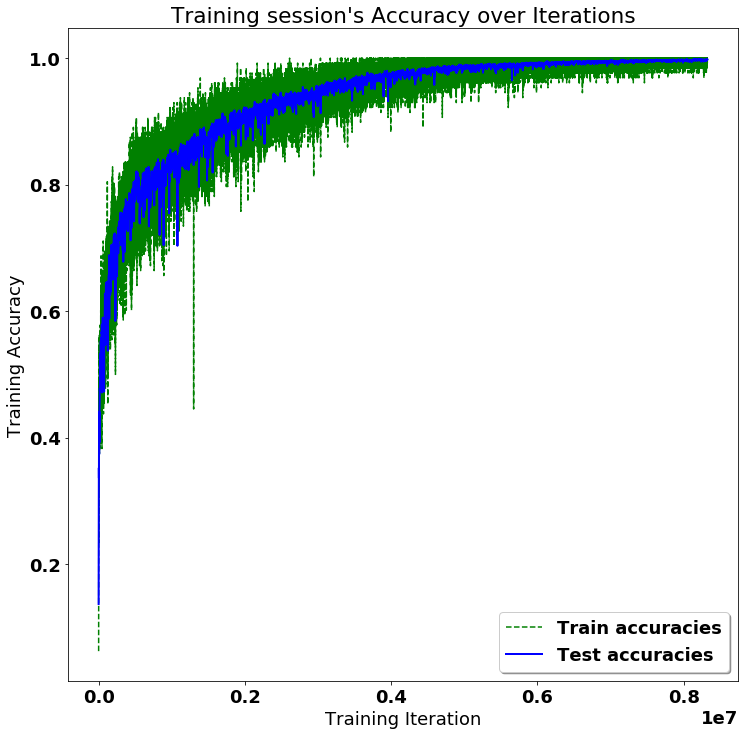

Testing Accuracy: 99.76007342338562%

Precision: 99.76053212997232%
Recall: 99.76007382343894%
f1_score: 99.76006551278923%

Confusion Matrix:
Created using test set of 32510 datapoints, normalised to % of each class in the test dataset


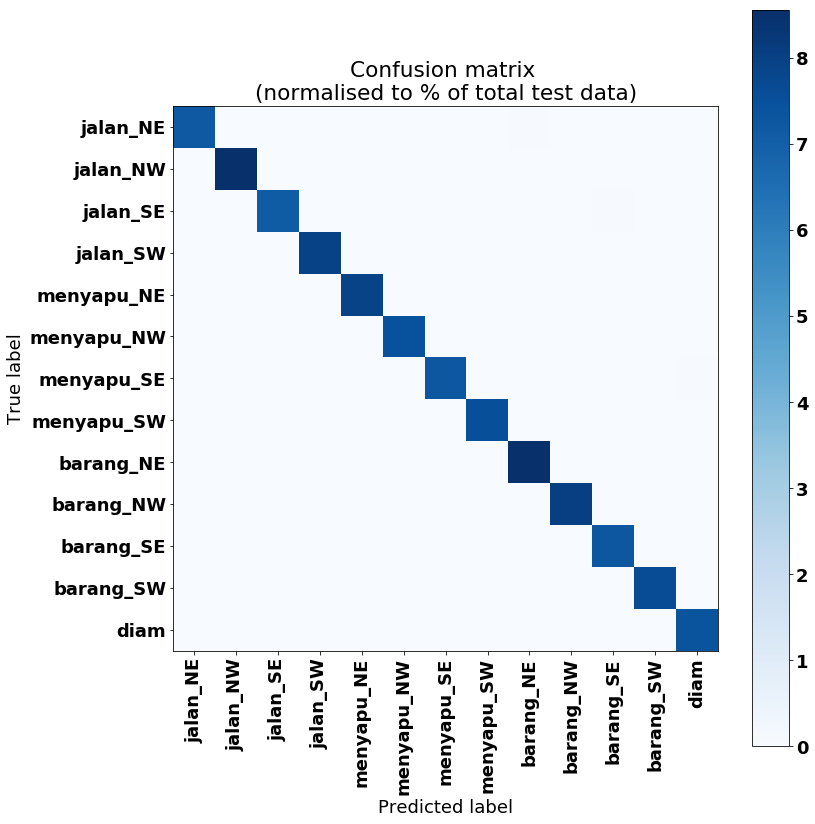

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.137004, 0.22343895, 0.2910489, 0.35216856, 0.33611196, 0.3979391, 0.38674253, 0.37366965, 0.440972, 0.40790525, 0.39261764, 0.43518916, 0.4458628, 0.45029223, 0.470932, 0.47283912, 0.47849894, 0.47311595, 0.48963395, 0.51396495, 0.52303904, 0.5323593, 0.5188865, 0.49234083, 0.49360198, 0.48803446, 0.48640418, 0.5089203, 0.54964626, 0.5527222, 0.5238696, 0.4964934, 0.53961855, 0.53688097, 0.558136, 0.5423562, 0.5254998, 0.5492156, 0.53420484, 0.5523839, 0.5665949, 0.5649031, 0.57007074, 0.578622, 0.49744695, 0.4713934, 0.52894497, 0.54773915, 0.54315597, 0.57000923, 0.5407567, 0.5492771, 0.55432177, 0.54860044, 0.5855429, 0.5897878, 0.5746539, 0.5721009, 0.5860966, 0.5840972, 0.5665334, 0.5523839, 0.5656721, 0.5252845, 0.525992, 0.56007385, 0.56828666, 0.58538914, 0.5401107, 0.54337126, 0.49147955, 0.5475546, 0.5313134, 0.47259304, 0.5226084, 0.5718856, 0.5552138, 0.5766841, 0.5645955, 0.57004, 0.5556444, 0.5935097, 0.6001538, 0.6115349, 0.62780684, 0.6192556, 0.6002153, 0.6010151, 0

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 1598943 bytes to LSTM.md
'mv' is not recognized as an internal or external command,
operable program or batch file.


## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
